### Name : Ashish Hanamant Thigale
### Roll No : 242262018

### Assignment 2 : Apache Spark Machine Learning - Regression

### ------------------------------------------------------------------------------------------------

 ### About Dataset

- This dataset captures the details of how CO2 emissions by a vehicle can vary with the different features. 
- The dataset has been taken from Canada Government official open data website. - This is a compiled version. This contains data over a period of 7 years.
- There are total 7385 rows and 12 columns.
- There are few abbreviations that has been used to describe the features. I am listing them out here.
1. Model
- 4WD/4X4 = Four-wheel drive
- AWD = All-wheel drive
- FFV = Flexible-fuel vehicle
- SWB = Short wheelbase
- LWB = Long wheelbase
- EWB = Extended wheelbase
2. Transmission
- A = Automatic
- AM = Automated manual
- AS = Automatic with select shift
- AV = Continuously variable
- M = Manual
- 3 - 10 = Number of gears
3. Fuel Type
- X = Regular gasoline
- Z = Premium gasoline
- D = Diesel
- E = Ethanol (E85)
- N = Natural gas

Note: The dataset has been derived from https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles

### Objective 

- Predict the CO2 emissions from various cars in Canada.

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [2]:
spark = SparkSession.builder.appName('Regression-Spark-ML').getOrCreate()

### Read the input file and check the columns

In [3]:
df = spark.read.csv('CO2 Emissions_Canada.csv',header=True,inferSchema=True)

In [4]:
df.show(5)

+-----+----------+-------------+--------------+---------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
| Make|     Model|Vehicle Class|Engine Size(L)|Cylinders|Transmission|Fuel Type|Fuel Consumption City (L/100 km)|Fuel Consumption Hwy (L/100 km)|Fuel Consumption Comb (L/100 km)|Fuel Consumption Comb (mpg)|CO2 Emissions(g/km)|
+-----+----------+-------------+--------------+---------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|ACURA|       ILX|      COMPACT|           2.0|        4|         AS5|        Z|                             9.9|                            6.7|                             8.5|                         33|                196|
|ACURA|       ILX|      COMPACT|           2.4|        4|          M6|        Z|            

In [5]:
df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Vehicle Class: string (nullable = true)
 |-- Engine Size(L): double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Fuel Consumption City (L/100 km): double (nullable = true)
 |-- Fuel Consumption Hwy (L/100 km): double (nullable = true)
 |-- Fuel Consumption Comb (L/100 km): double (nullable = true)
 |-- Fuel Consumption Comb (mpg): integer (nullable = true)
 |-- CO2 Emissions(g/km): integer (nullable = true)



In [6]:
df.describe().toPandas()

,summary,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,count,7385,7385,7385,7385,7385,7385,7385,7385,7385,7385,7385,7385
1,mean,None,535.0967741935484,None,3.1600677048070125,5.615030467163169,None,None,12.556533513879508,9.04170616113748,10.97507109004736,27.48165199729181,250.58469871360867
2,stddev,None,545.068274306911,None,1.3541704555622625,1.8283065156997265,None,None,3.5002740810878024,2.2244563806418762,2.892506302898469,7.231879172141872,58.51267939440643
3,min,ACURA,124 SPIDER,COMPACT,0.9,3,A10,D,4.2,4.0,4.1,11,96
4,max,VOLVO,xD,VAN - PASSENGER,8.4,16,M7,Z,30.6,20.6,26.1,69,522


### Data Exploration

- Check for NaN,None,Null values

In [7]:
print('Columns Overview')
pd.DataFrame(data = df.dtypes,columns=['Column Name','Data Type'])

Columns Overview


,Column Name,Data Type
0,Make,string
1,Model,string
2,Vehicle Class,string
3,Engine Size(L),double
4,Cylinders,int
5,Transmission,string
6,Fuel Type,string
7,Fuel Consumption City (L/100 km),double
8,Fuel Consumption Hwy (L/100 km),double
9,Fuel Consumption Comb (L/100 km),double


In [8]:
string_col = ['Make','Model','Vehicle Class','Transmission','Fuel type']
int_col = ['Cylinders','Fuel Consumption Comb (mpg)','CO2 Emissions(g/km)']
array_col = ['Engine Size(L)','Fuel Consumption City (L/100 km)','Fuel Consumption Hwy (L/100 km)','Fuel Consumption Comb (L/100 km)']
missing_values = {}
for index,column in enumerate(df.columns):
    if column in string_col:
        missing_count = df.filter(f.col(column).eqNullSafe(None) | f.col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in int_col:
        missing_count = df.where(f.col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_col:
        missing_count = df.where(f.col(column).isin([0,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df.count()

7385

In [10]:
df.select('Make').distinct().count()

42

In [11]:
df.select('Make').distinct().show()

+-----------+
|       Make|
+-----------+
|      ACURA|
|LAMBORGHINI|
|    PORSCHE|
|    HYUNDAI|
|       FIAT|
|     TOYOTA|
|        RAM|
|     SUBARU|
|     NISSAN|
|    BENTLEY|
|   INFINITI|
|       AUDI|
|       FORD|
|       MINI|
| ALFA ROMEO|
|        SRT|
|      DODGE|
|  CHEVROLET|
|     JAGUAR|
|    BUGATTI|
+-----------+
only showing top 20 rows



In [12]:
df.select('Model').distinct().count()

2053

In [13]:
df.select('Vehicle Class').distinct().count()

16

In [14]:
df.select('Vehicle Class').distinct().show()

+--------------------+
|       Vehicle Class|
+--------------------+
|         MINICOMPACT|
|SPECIAL PURPOSE V...|
|             COMPACT|
|         VAN - CARGO|
|      SUV - STANDARD|
|         SUV - SMALL|
|PICKUP TRUCK - ST...|
|STATION WAGON - M...|
|          TWO-SEATER|
|          SUBCOMPACT|
|            MID-SIZE|
|PICKUP TRUCK - SMALL|
|           FULL-SIZE|
|STATION WAGON - S...|
|             MINIVAN|
|     VAN - PASSENGER|
+--------------------+



In [15]:
df.select('Transmission').distinct().count()

27

In [16]:
df.select('Transmission').distinct().show()

+------------+
|Transmission|
+------------+
|         AS4|
|        AS10|
|          A9|
|        AV10|
|         AM5|
|          A6|
|          M7|
|          A8|
|          AV|
|         AM9|
|         AS9|
|         AS6|
|          M6|
|         AV8|
|         AV6|
|         AS7|
|         A10|
|         AS8|
|          A4|
|          M5|
+------------+
only showing top 20 rows



- Note : Mapping similar labels into a single label for Transmission column

In [17]:
A = ["A4", "A5", "A6", "A7", "A8", "A9", "A10"]
AM = ["AM5", "AM6", "AM7", "AM8", "AM9"]
ASS = ["AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "AS10"]
CV = ["AV", "AV6", "AV7", "AV8", "AV10"]
M = ["M5", "M6", "M7"]

df = df.replace(A,'Automatic','Transmission')
df = df.replace(AM,'Automated Manual','Transmission')
df = df.replace(ASS ,'Automatic with Select Shift','Transmission')
df = df.replace(CV,'Continuously Variable','Transmission')
df = df.replace(M ,'Manual','Transmission')
df.show()

+------------+------------+-------------+--------------+---------+--------------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|        Make|       Model|Vehicle Class|Engine Size(L)|Cylinders|        Transmission|Fuel Type|Fuel Consumption City (L/100 km)|Fuel Consumption Hwy (L/100 km)|Fuel Consumption Comb (L/100 km)|Fuel Consumption Comb (mpg)|CO2 Emissions(g/km)|
+------------+------------+-------------+--------------+---------+--------------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+-------------------+
|       ACURA|         ILX|      COMPACT|           2.0|        4|Automatic with Se...|        Z|                             9.9|                            6.7|                             8.5|                         33|                196|
|       ACURA|         I

In [18]:
df.select('Transmission').distinct().show()

+--------------------+
|        Transmission|
+--------------------+
|Continuously Vari...|
|           Automatic|
|Automatic with Se...|
|              Manual|
|    Automated Manual|
+--------------------+



### Visualizations

- Pyspark dataframe has limitation in visualization. Then to create visualization we have to convert pyspark dataframe to pandas dataframe.

In [19]:
df_pd = df.toPandas()

### 1. CO2 Emissions 

<AxesSubplot:ylabel='CO2 Emissions(g/km)'>

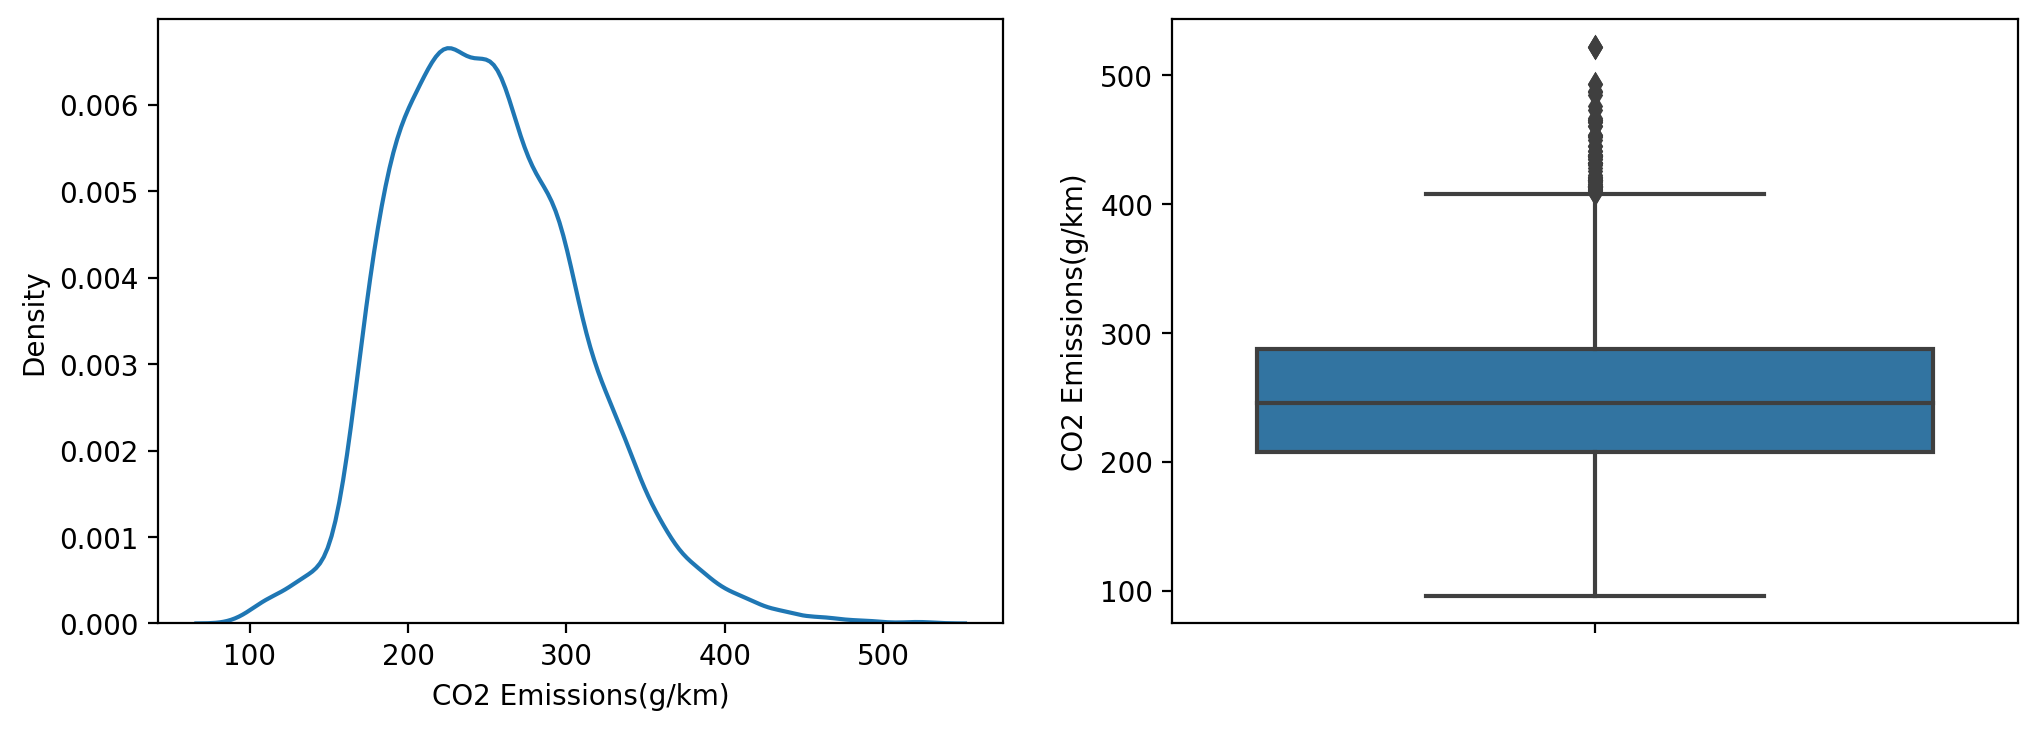

In [20]:
plt.figure(figsize = (12,4), dpi = 200)

plt.subplot(1,2,1)
sns.distplot(df_pd['CO2 Emissions(g/km)'], hist = False)

plt.subplot(1,2,2)
sns.boxplot(y = df_pd['CO2 Emissions(g/km)'])

### 2. Make

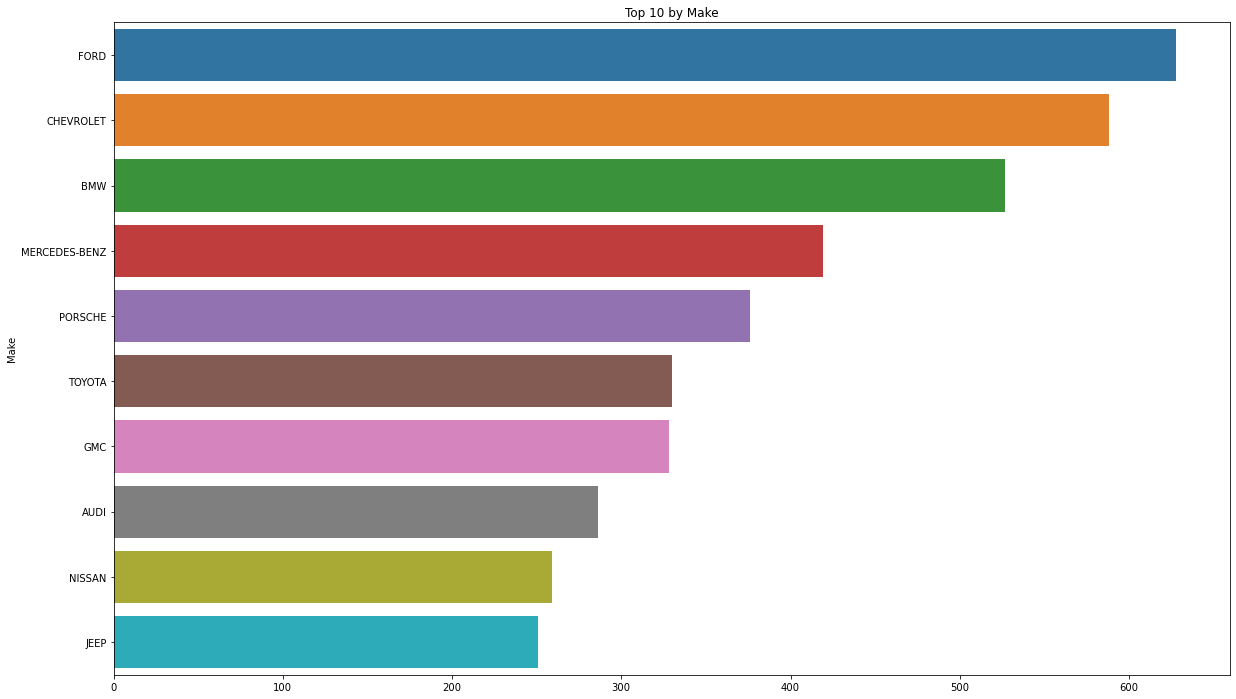

In [21]:
Top_10_Make = df_pd.groupby('Make')['Make'].count().sort_values(ascending=False).head(10)
plt.figure(figsize = (20,12))
sns.barplot(y = Top_10_Make.index, x=Top_10_Make.values)
plt.title('Top 10 by Make')
plt.show()


- Conclusion -  Most of the cars on Canadian roads are made by Ford

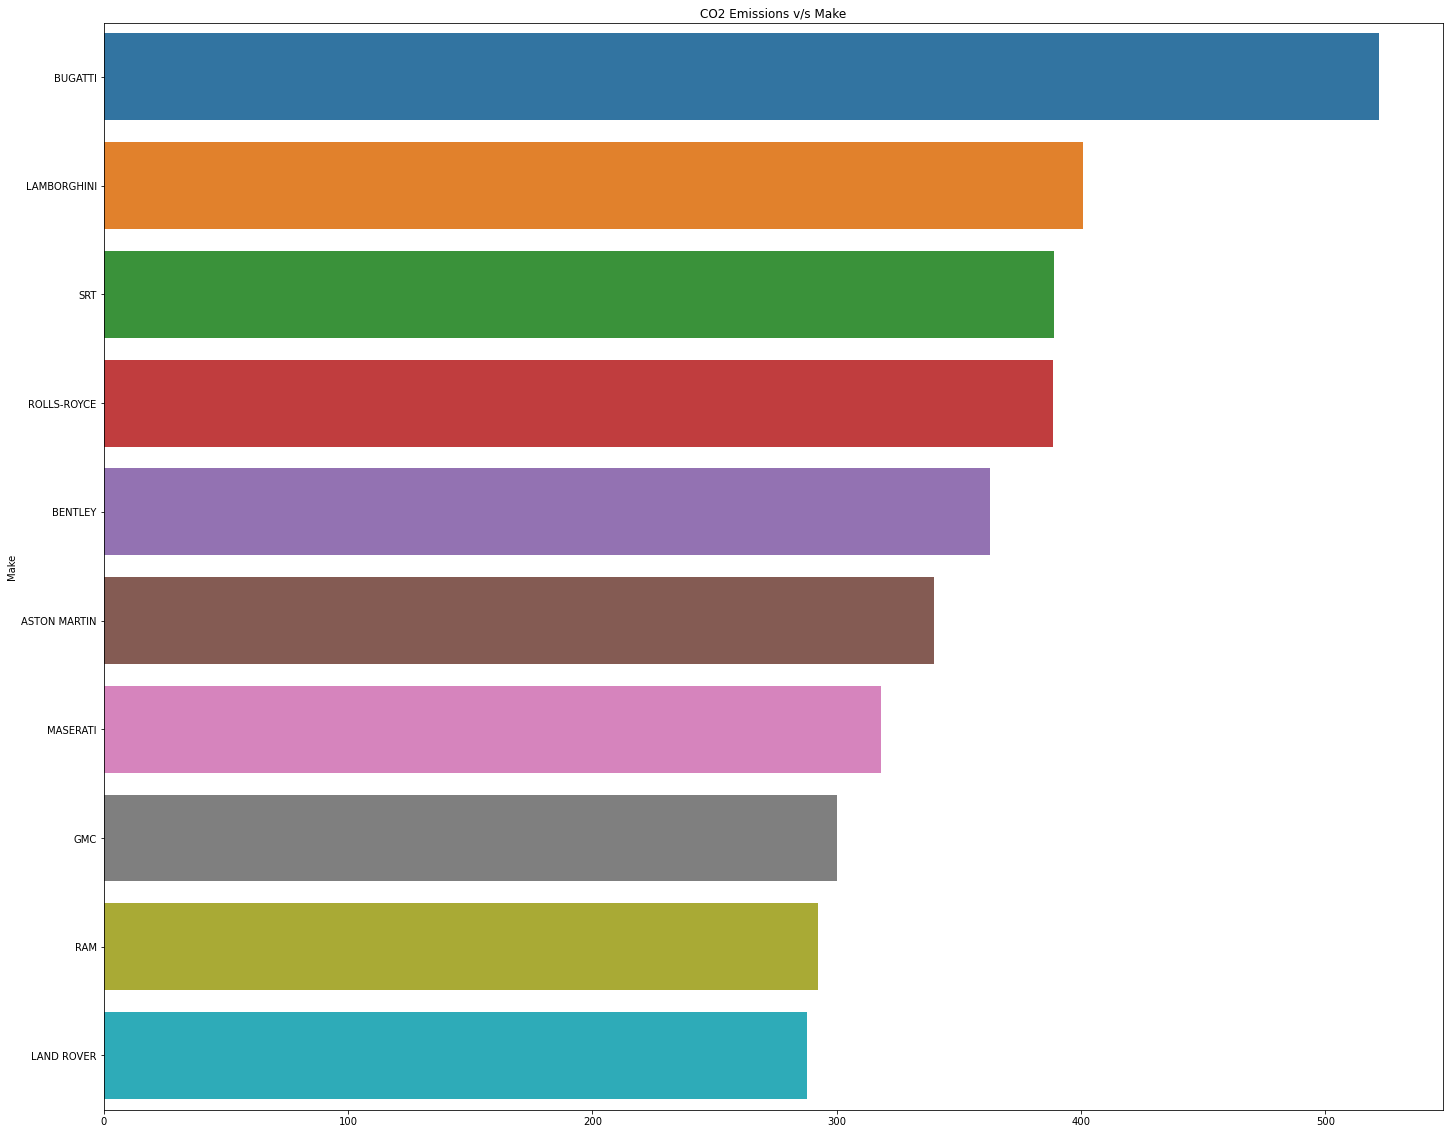

In [22]:
Make_CO2 = df_pd.groupby('Make')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(24,20))
sns.barplot(x=Make_CO2.values,y=Make_CO2.index )
plt.title('CO2 Emissions v/s Make')
plt.show()

- Conclusion - While Ford cars are mainly found on the roads of Canada , its Bugatti that emit the most CO2 per car

### 3. Model

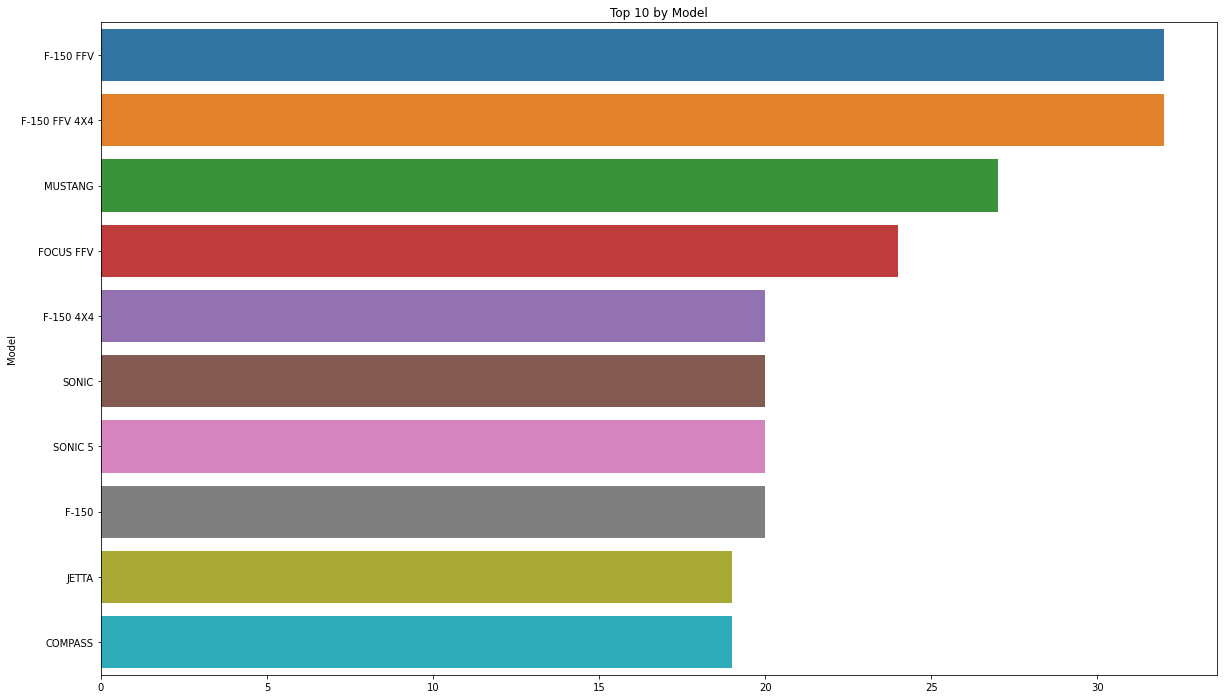

In [23]:
Top_10_Model = df_pd.groupby('Model')['Model'].count().sort_values(ascending=False).head(10)
plt.figure(figsize = (20,12))
sns.barplot(y = Top_10_Model.index, x=Top_10_Model.values)
plt.title('Top 10 by Model')
plt.show()

- Conclusion - The F-150 FFV is amongst the most famous models driven in Canada

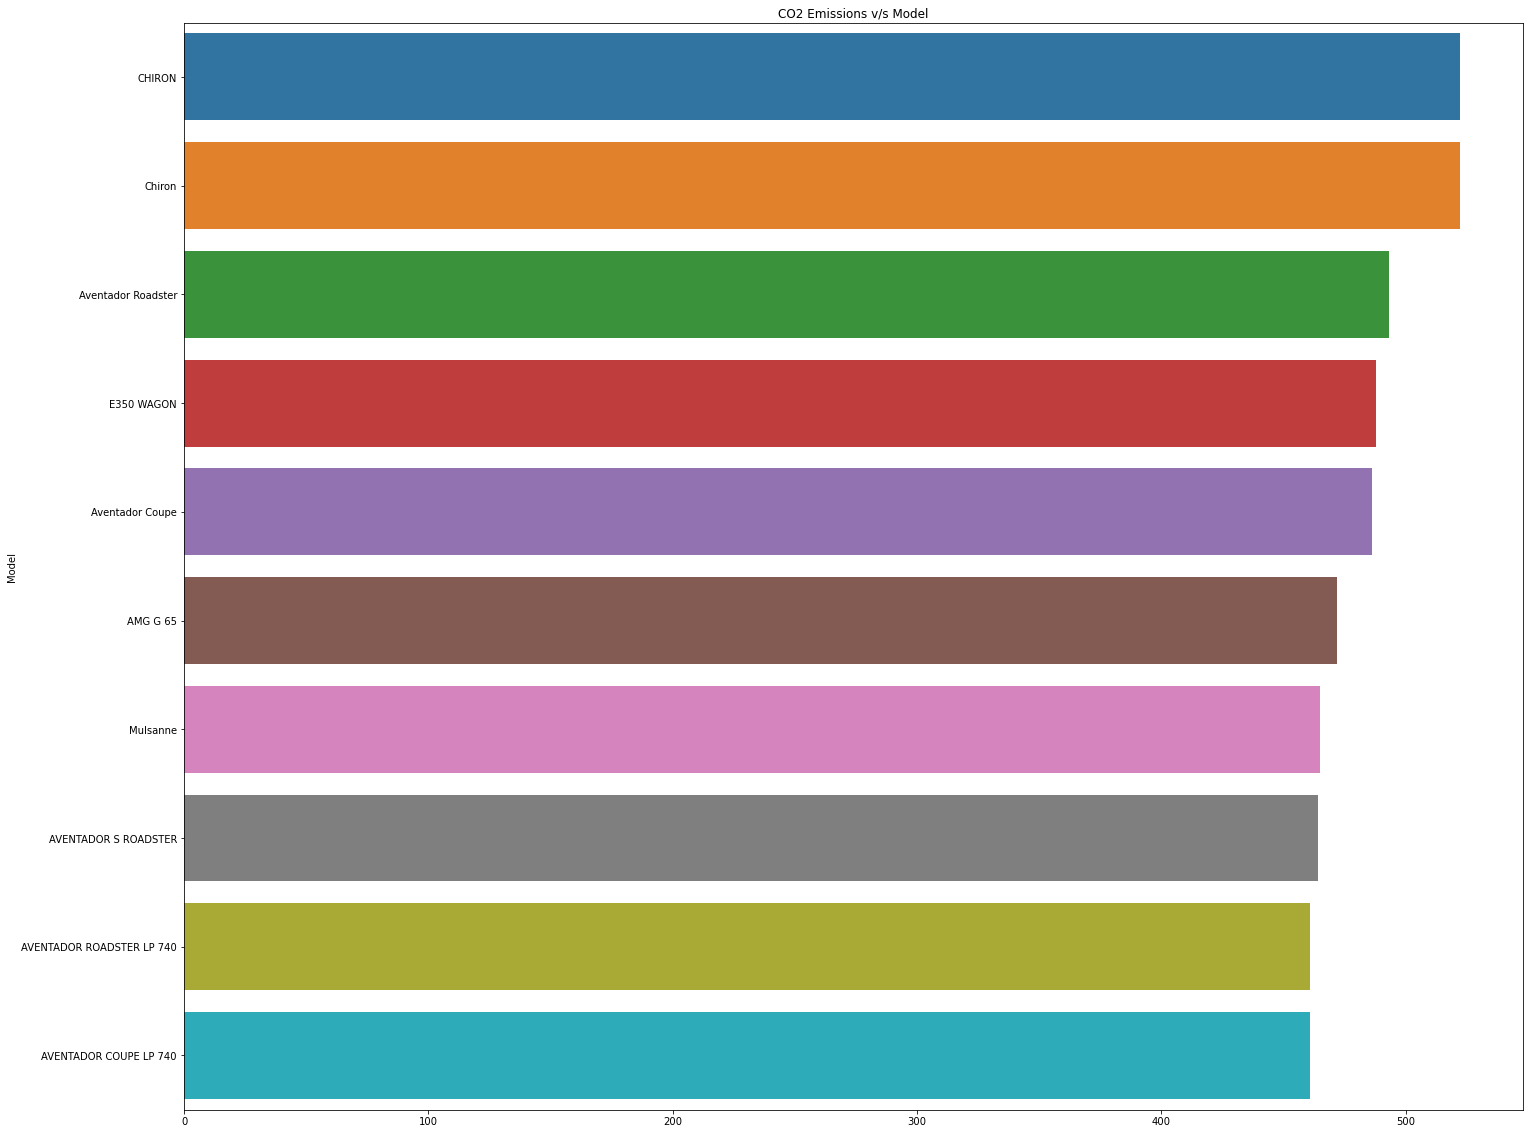

In [24]:
Model_CO2 = df_pd.groupby('Model')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(24,20))
sns.barplot(x=Model_CO2.values,y=Model_CO2.index )
plt.title('CO2 Emissions v/s Model')
plt.show()

- Conclusion - Bugatti Chiron is amongst the most CO2 emitting car model

### 4. Vehicle class

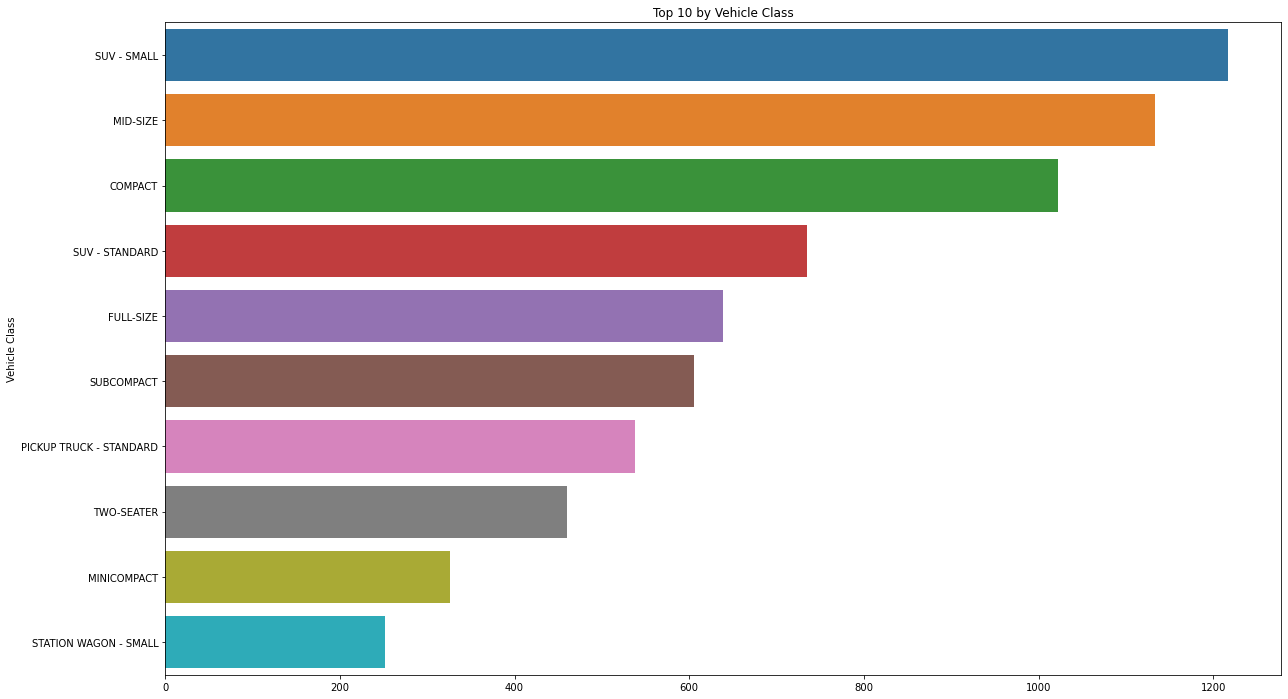

In [25]:
Top_10_Vehicle_class = df_pd.groupby('Vehicle Class')['Vehicle Class'].count().sort_values(ascending=False).head(10)
plt.figure(figsize = (20,12))
sns.barplot(y = Top_10_Vehicle_class.index, x=Top_10_Vehicle_class.values)
plt.title('Top 10 by Vehicle Class')
plt.show()

- Conclusion -  SUV-Small is the preferred class of vehicle amongst the Canadians

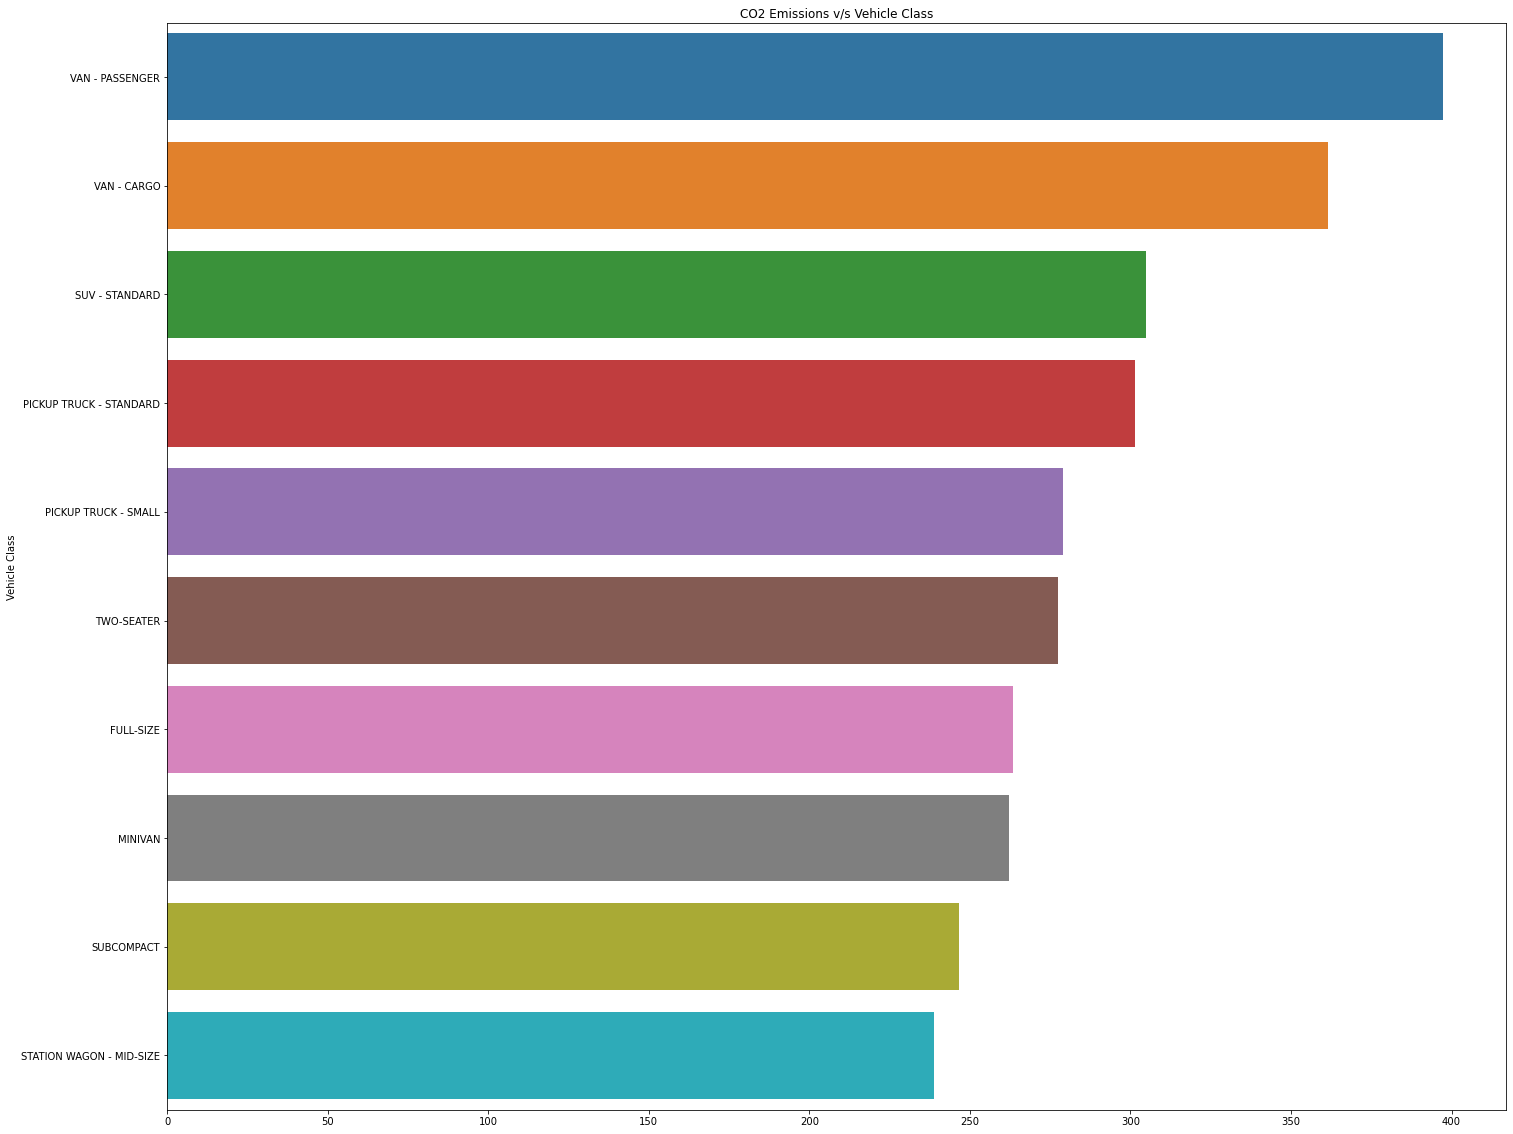

In [26]:
Vehicle_class_CO2 = df_pd.groupby('Vehicle Class')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(24,20))
sns.barplot(x=Vehicle_class_CO2.values,y=Vehicle_class_CO2.index )
plt.title('CO2 Emissions v/s Vehicle Class')
plt.show()

- Conclusion - Most of the heavy vehicles like Vans , SUV and Pick-up truck are amongst the top few emitters of CO2

### 5. Transmission

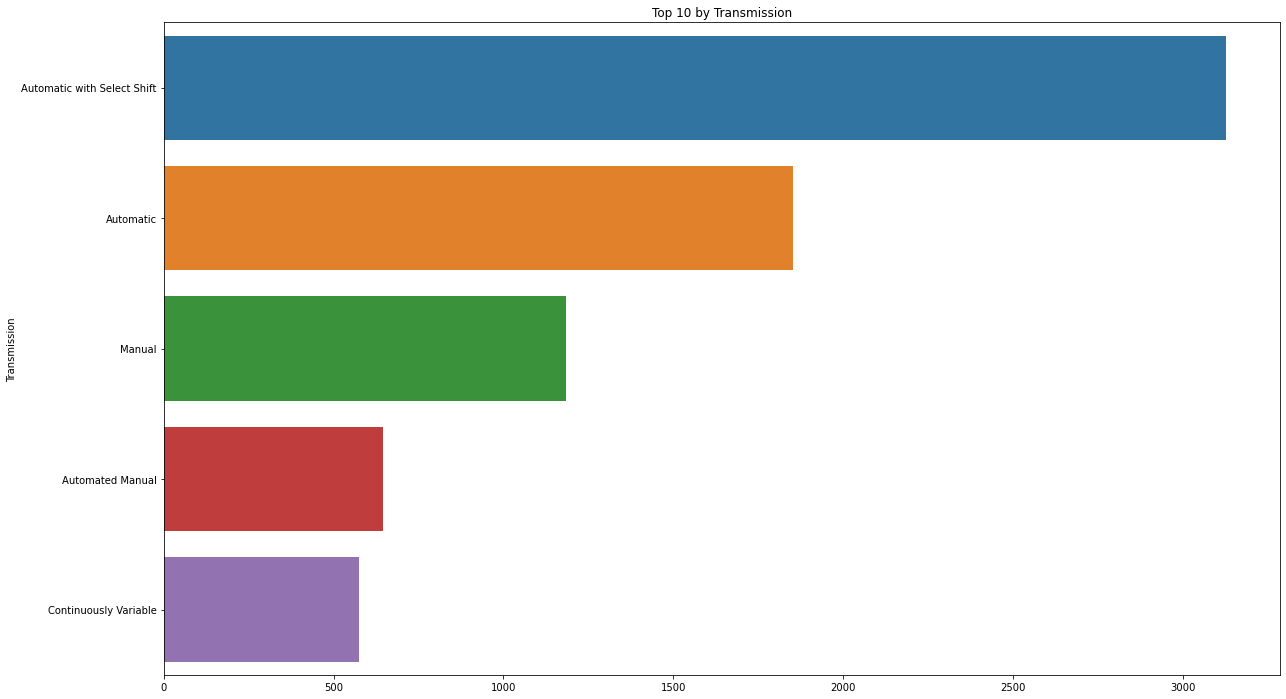

In [27]:
Top_10_Transmission = df_pd.groupby('Transmission')['Transmission'].count().sort_values(ascending=False).head(10)
plt.figure(figsize = (20,12))
sns.barplot(y = Top_10_Transmission.index, x=Top_10_Transmission.values)
plt.title('Top 10 by Transmission')
plt.show()

- Conclusion - Vehicles with Automatic with Select shift transmission are popular in Canada

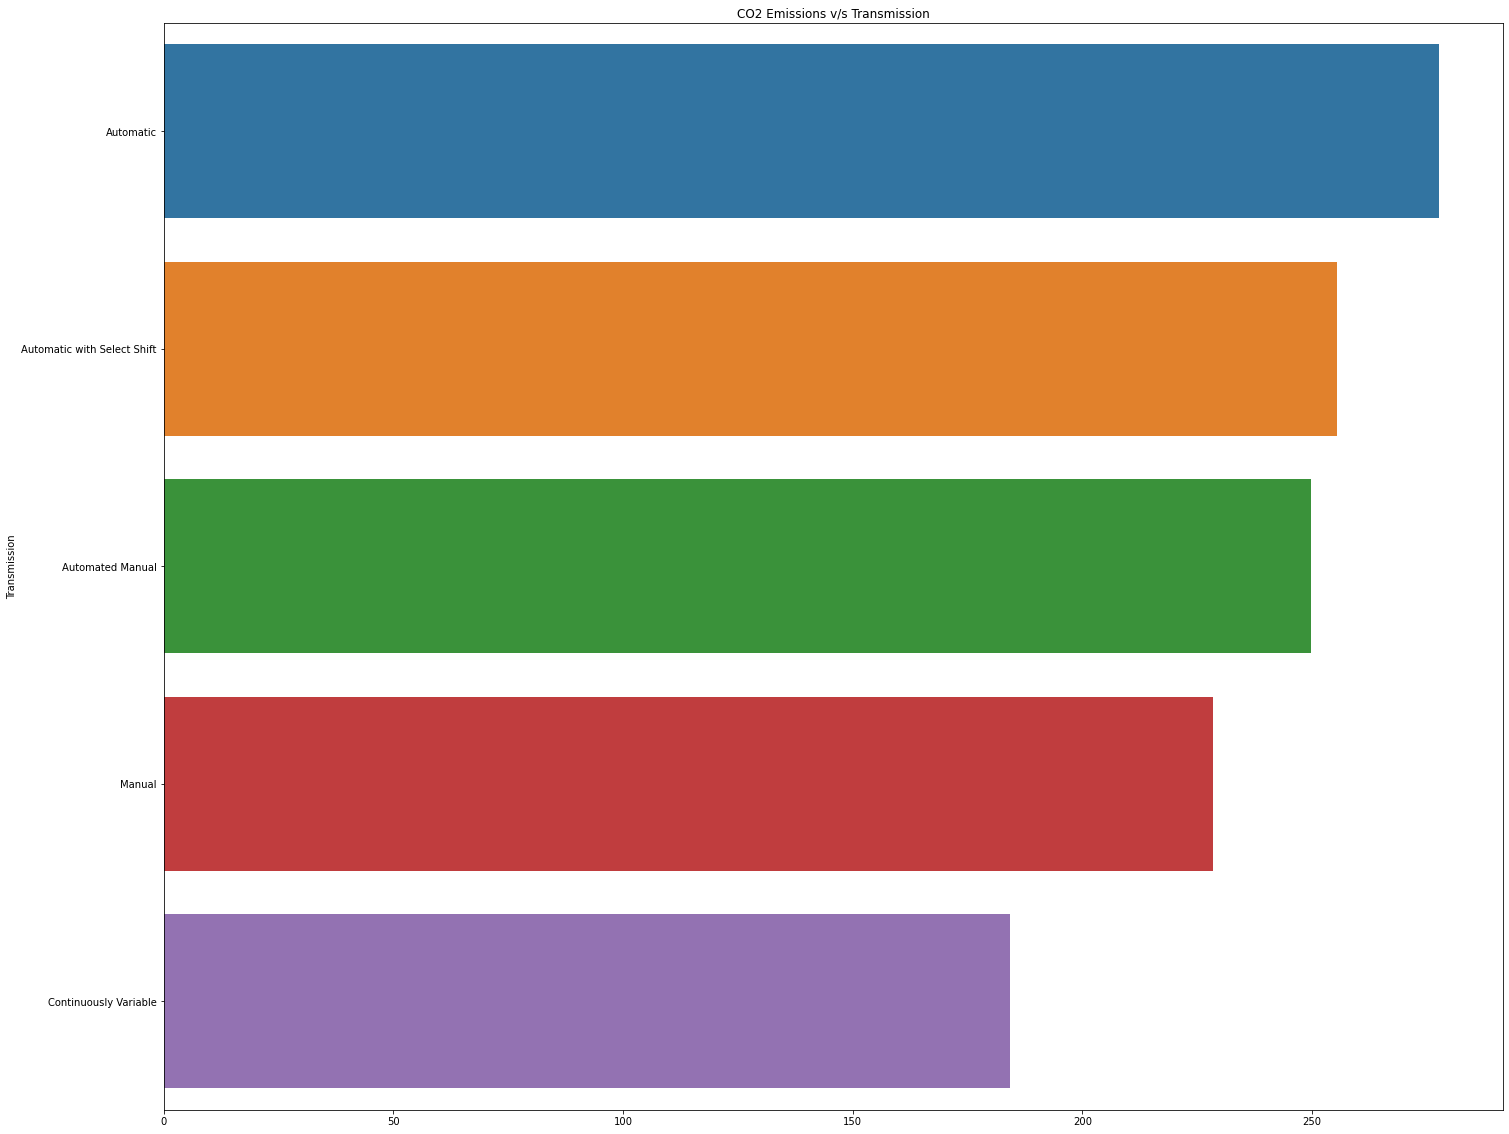

In [28]:
Transmission_CO2 = df_pd.groupby('Transmission')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(24,20))
sns.barplot(x=Transmission_CO2.values,y=Transmission_CO2.index )
plt.title('CO2 Emissions v/s Transmission')
plt.show()

- Conclusion - Most of the cars with Automatic transmission emit high amount of  CO2

### 6. Fuel Type

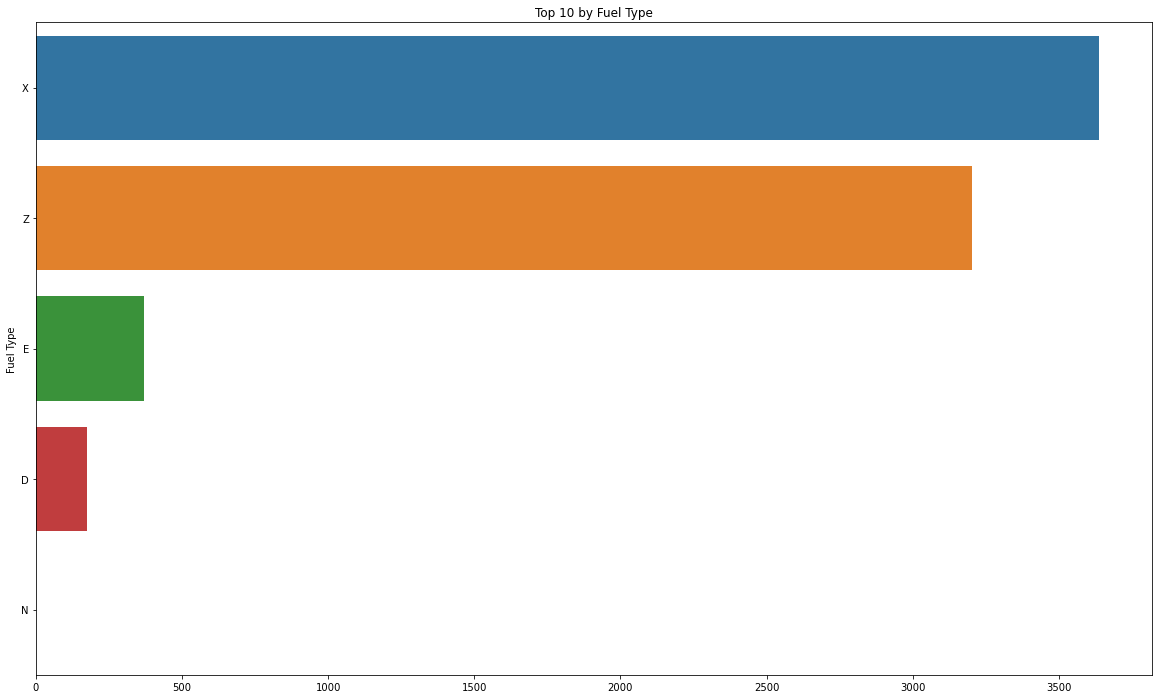

In [29]:
Top_10_Fuel_type = df_pd.groupby('Fuel Type')['Fuel Type'].count().sort_values(ascending=False).head(10)
plt.figure(figsize = (20,12))
sns.barplot(y = Top_10_Fuel_type.index, x=Top_10_Fuel_type.values)
plt.title('Top 10 by Fuel Type')
plt.show()

- Conclusion - Majority of the cars in Canada use Fuel type X (Regular Gasoline) and Z (Premium Gasoline)

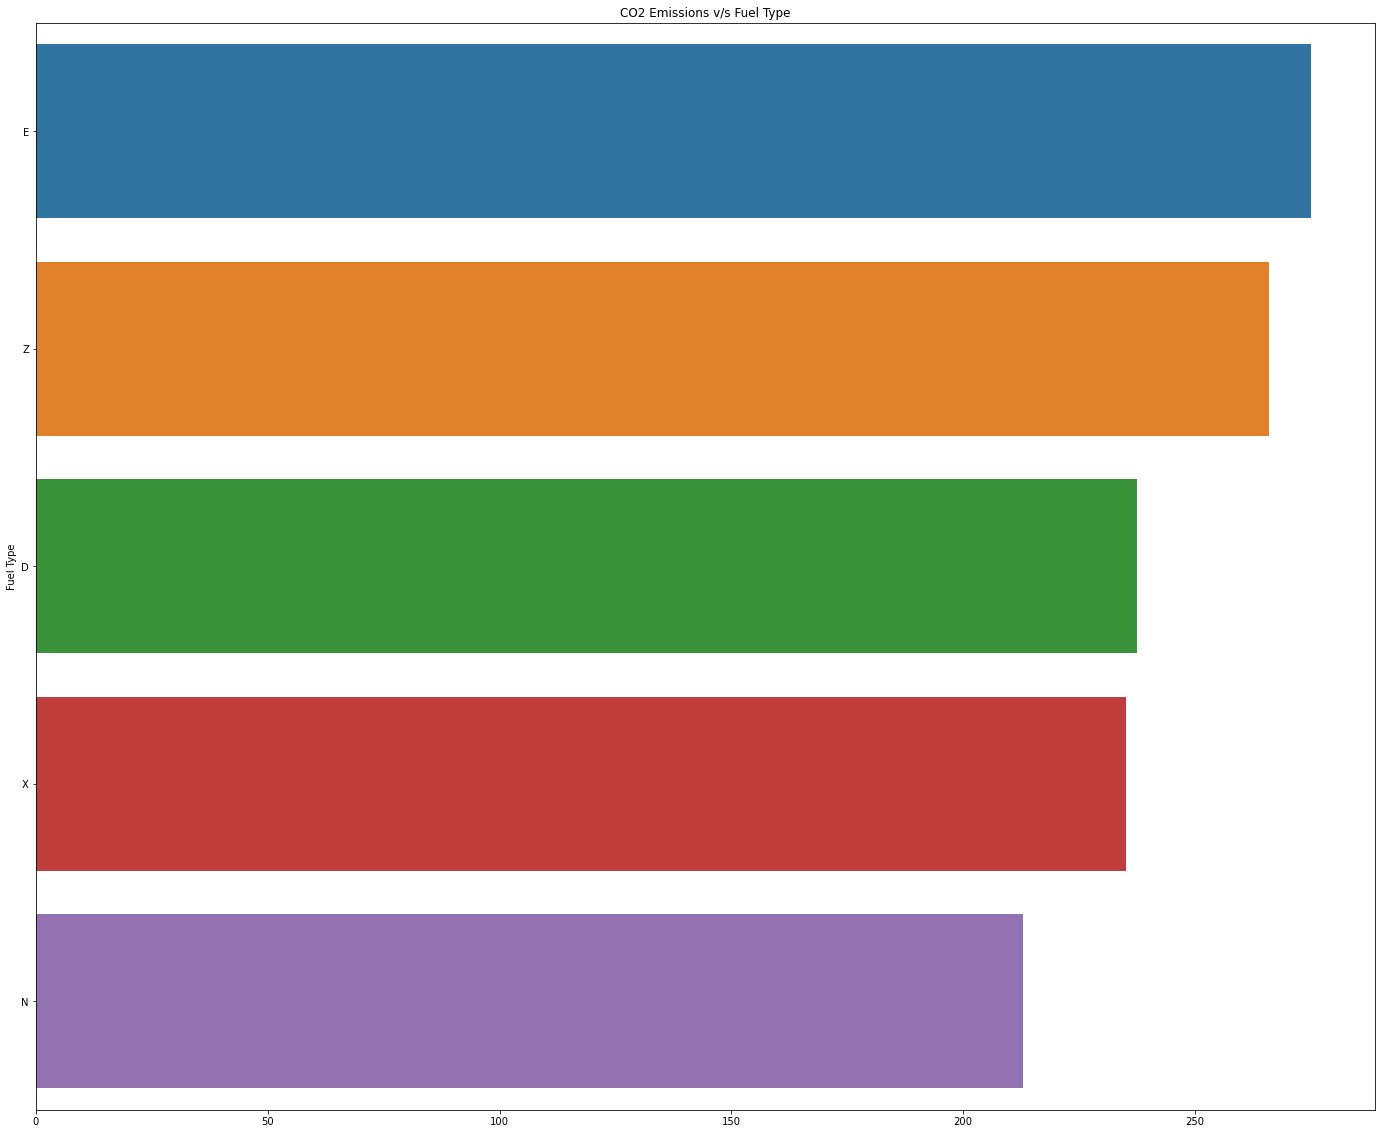

In [30]:
Fuel_type_CO2 = df_pd.groupby('Fuel Type')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(24,20))
sns.barplot(x=Fuel_type_CO2.values,y=Fuel_type_CO2.index )
plt.title('CO2 Emissions v/s Fuel Type')
plt.show()

- Conclusion - Cars using Fuel Type E (Ethanol E85) are emitting the most CO2

### 7. Cylinders

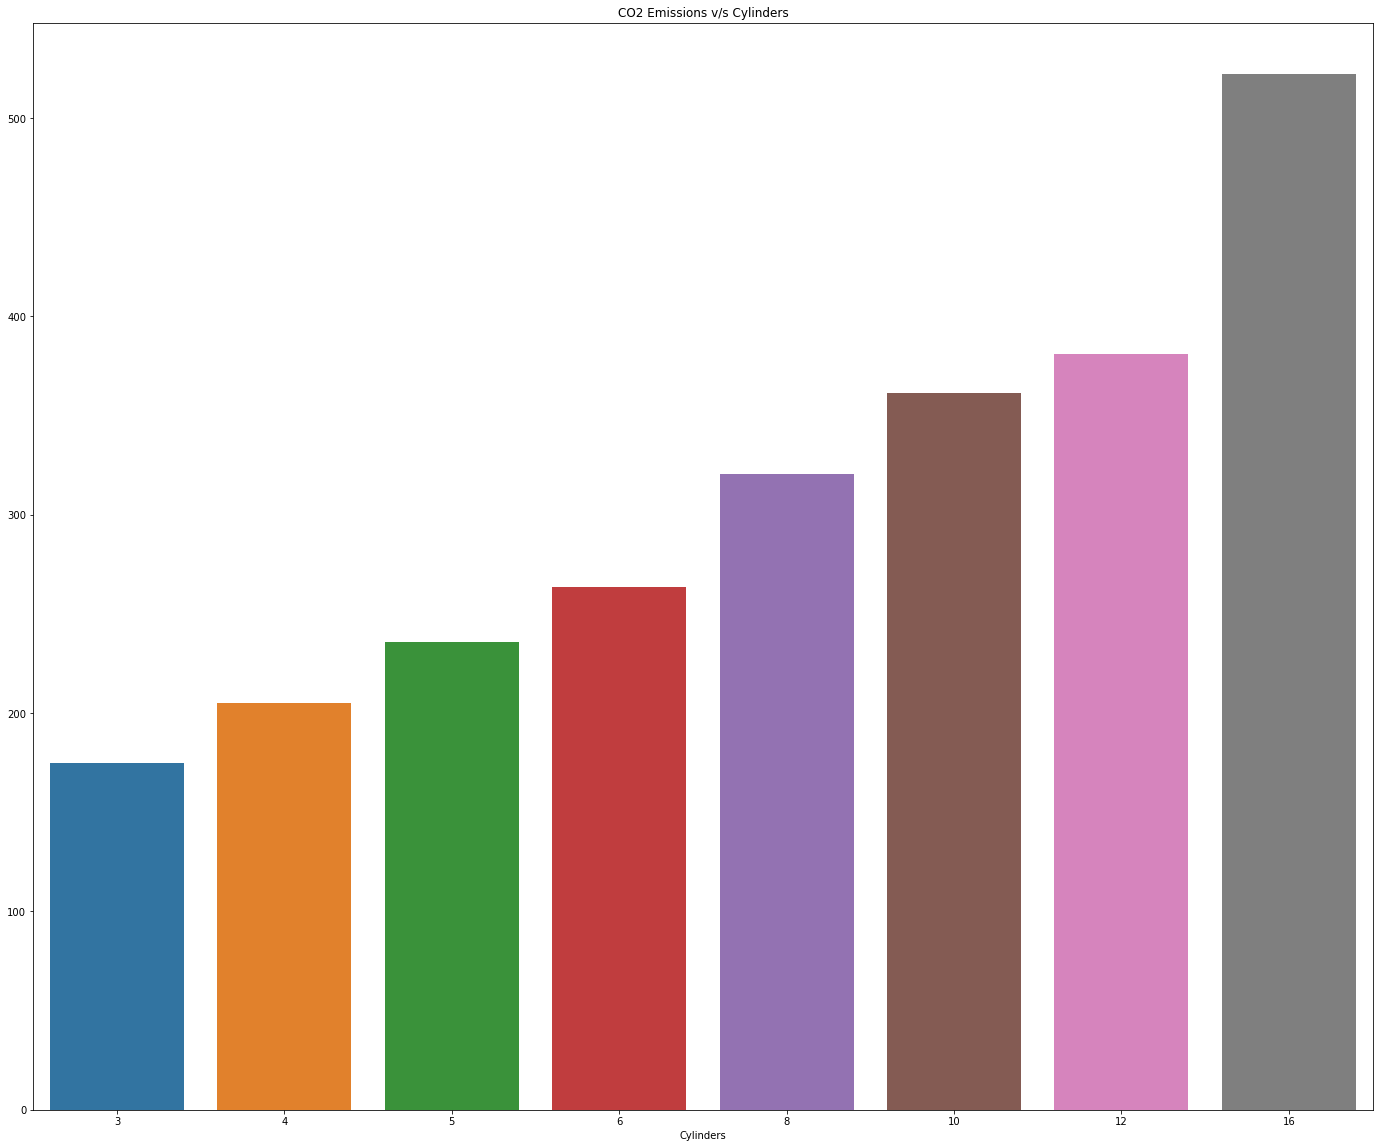

In [31]:
Cylinders_CO2 = df_pd.groupby('Cylinders')['CO2 Emissions(g/km)'].mean().sort_values(ascending = False)

plt.figure(figsize=(24,20))
sns.barplot(y=Cylinders_CO2.values,x=Cylinders_CO2.index )
plt.title('CO2 Emissions v/s Cylinders')
plt.show()

- Conclusion -  As the number of cylinders increase, the CO2 emissions increase


### 8. Fuel Consumption with No. of cylinders

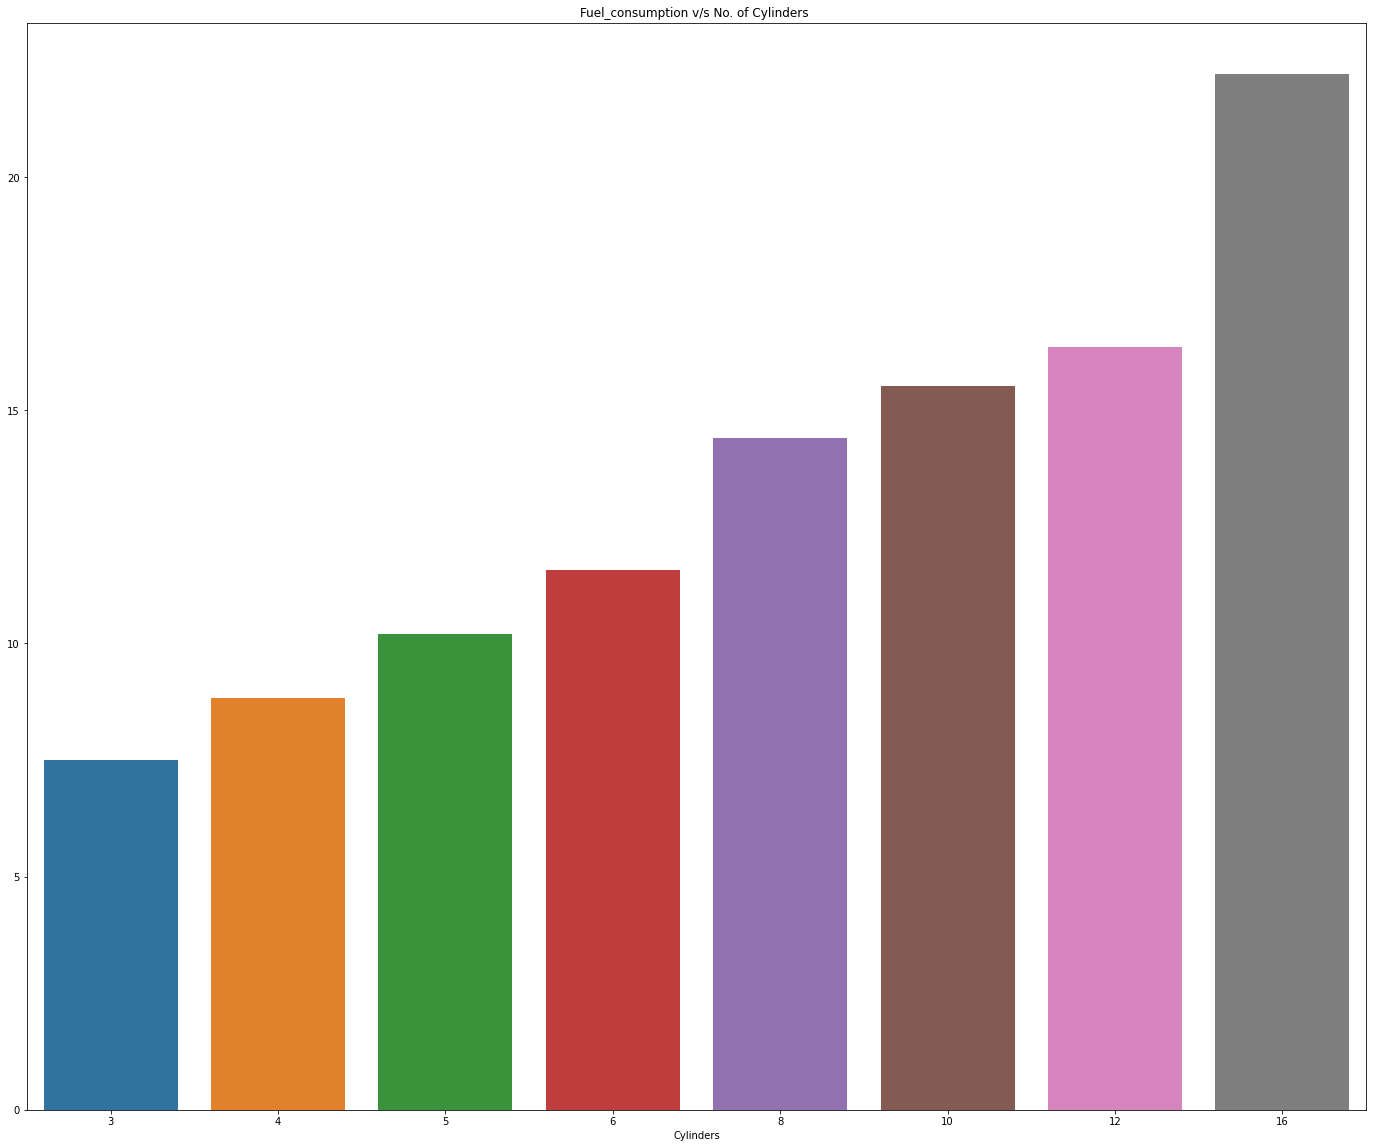

In [32]:
Fuel_consumption_cylinder = df_pd.groupby('Cylinders')['Fuel Consumption Comb (L/100 km)'].mean().sort_values(ascending = False)

plt.figure(figsize=(24,20))
sns.barplot(y=Fuel_consumption_cylinder.values,x=Fuel_consumption_cylinder.index )
plt.title('Fuel_consumption v/s No. of Cylinders ')
plt.show()

- Conclusion - As the number of cylinders increases, fuel consumption increases so with increase in number of cylinders, CO2 emission also increases.

### 9. Engine Size (L)

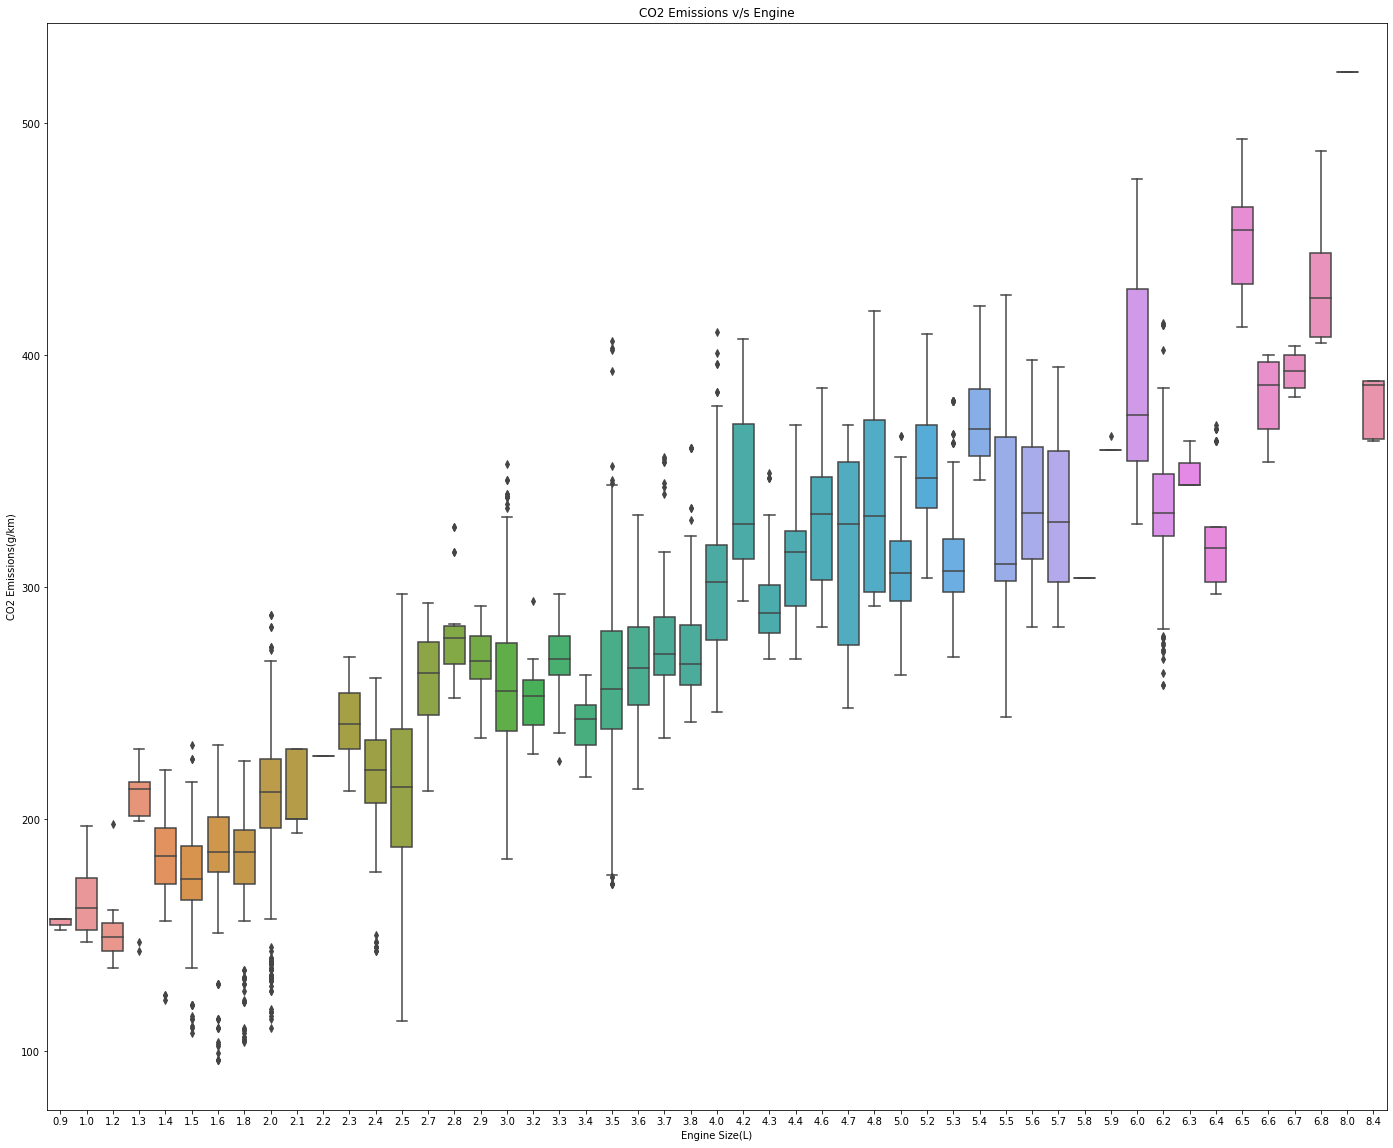

In [33]:
Engine_CO2 = df_pd.groupby('Engine Size(L)')['CO2 Emissions(g/km)'].median().index

plt.figure(figsize=(24,20))
sns.boxplot(y=df_pd['CO2 Emissions(g/km)'],x=df_pd['Engine Size(L)'],order = Engine_CO2)
plt.title('CO2 Emissions v/s Engine')
plt.show()

- Conclusion - With increase in Engine Size, CO2 emissions also increases.

### 10. Fuel Consumption City (L/100 km)

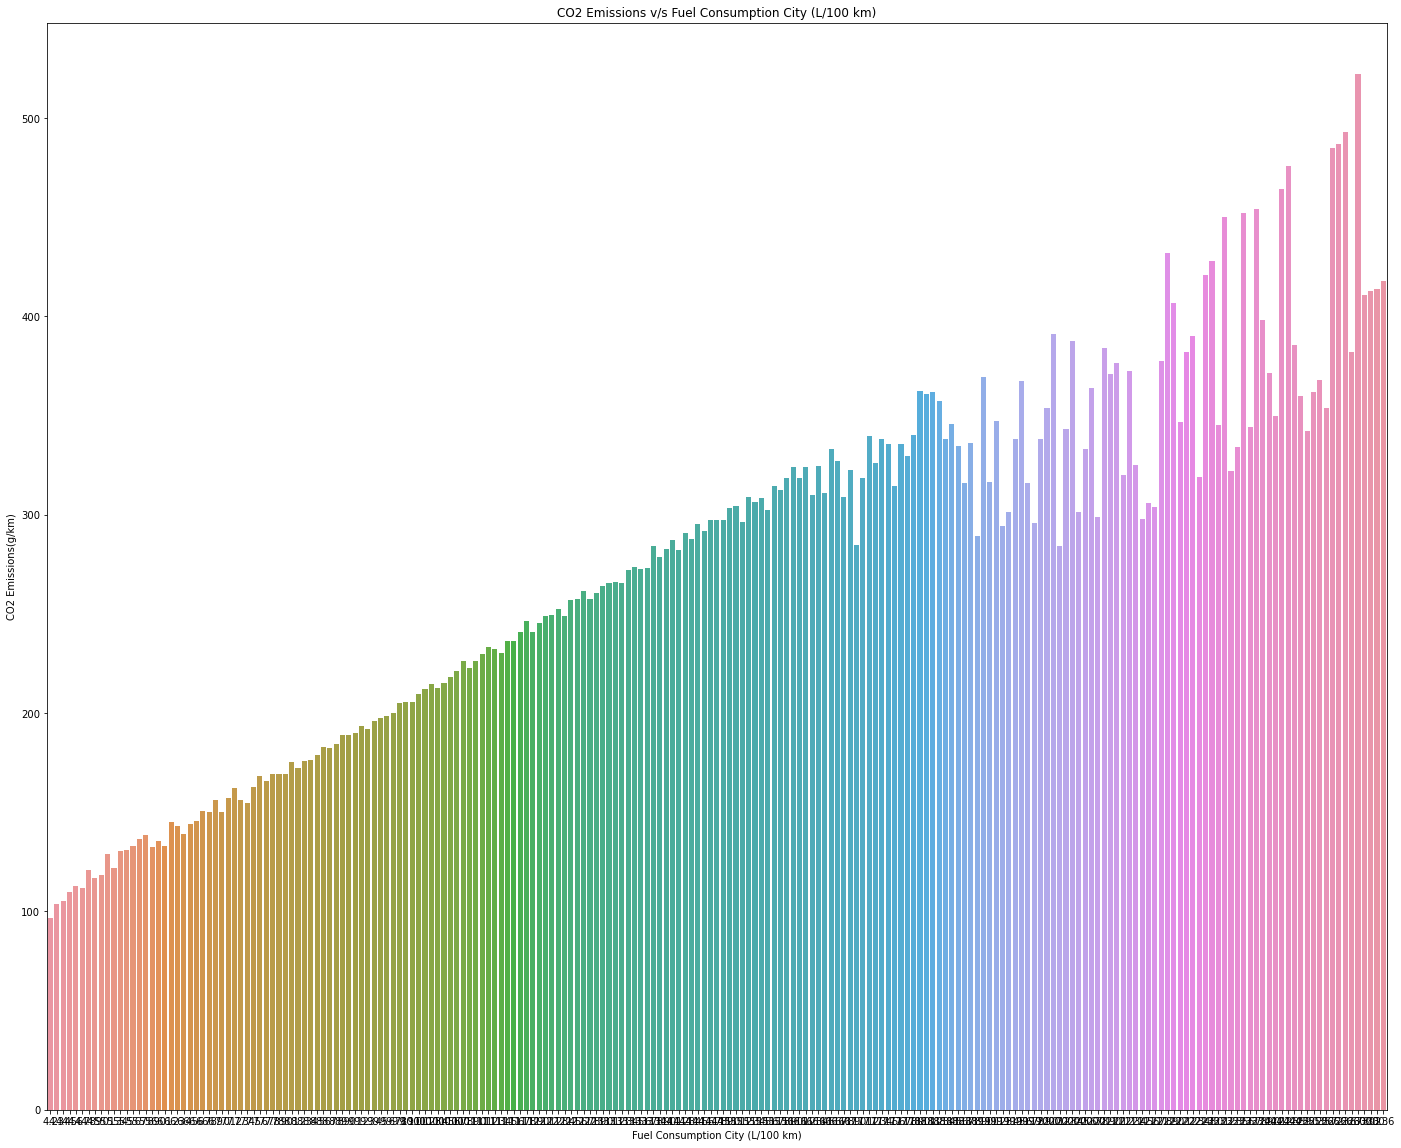

In [34]:
city_CO2 = df_pd.groupby('Fuel Consumption City (L/100 km)')['CO2 Emissions(g/km)'].mean().reset_index()
plt.figure(figsize=(24,20))
sns.barplot(y='CO2 Emissions(g/km)',x='Fuel Consumption City (L/100 km)',data = city_CO2)
plt.title('CO2 Emissions v/s Fuel Consumption City (L/100 km)')
plt.show()

- Conclusion - As Fuel Consumption City (L/100 km) increases, CO2 emissions increases

### 11. Fuel Consumption Hwy (L/100 km)

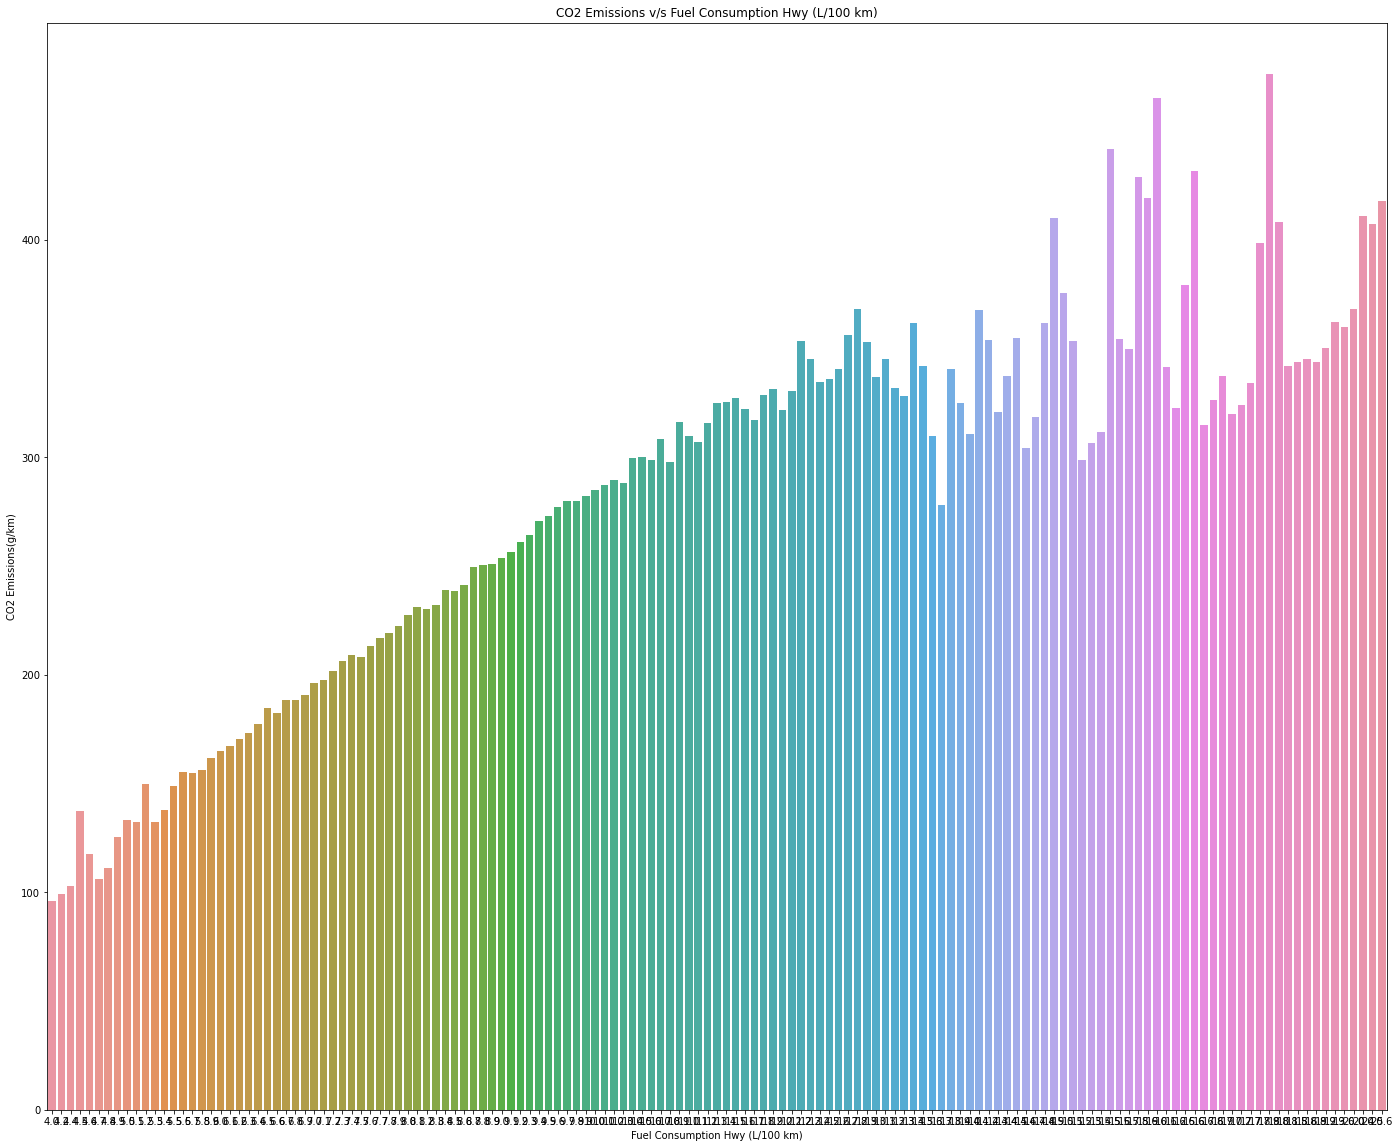

In [35]:
Hwy_CO2 = df_pd.groupby('Fuel Consumption Hwy (L/100 km)')['CO2 Emissions(g/km)'].mean().reset_index()
plt.figure(figsize=(24,20))
sns.barplot(y='CO2 Emissions(g/km)',x='Fuel Consumption Hwy (L/100 km)',data = Hwy_CO2)
plt.title('CO2 Emissions v/s Fuel Consumption Hwy (L/100 km)')
plt.show()

- Conclusion - As Fuel Consumption Hwy (L/100 km) increases, CO2 emissions increases

### 12. Fuel Consumption Comb (L/100 km)

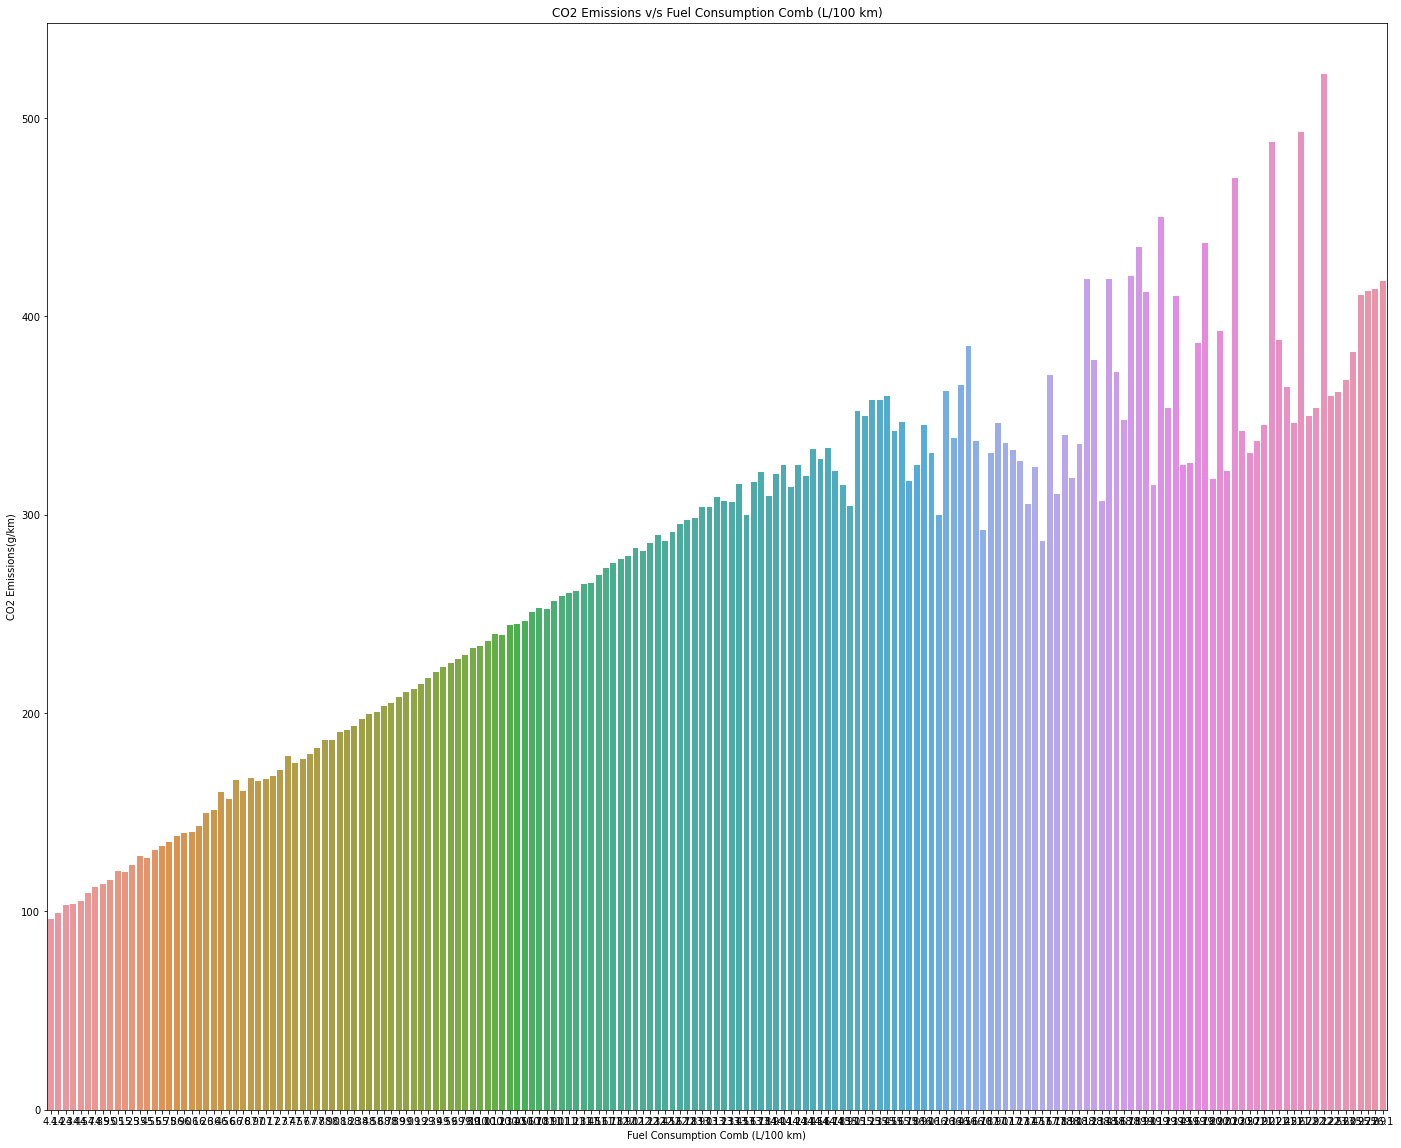

In [36]:
Comb_CO2 = df_pd.groupby('Fuel Consumption Comb (L/100 km)')['CO2 Emissions(g/km)'].mean().reset_index()
plt.figure(figsize=(24,20))
sns.barplot(y='CO2 Emissions(g/km)',x='Fuel Consumption Comb (L/100 km)',data = Comb_CO2)
plt.title('CO2 Emissions v/s Fuel Consumption Comb (L/100 km)')
plt.show()

- Conclusion - As Fuel Consumption Comb (L/100 km) increases, CO2 emissions increases

### 13. Fuel Consumption Comb (mpg)

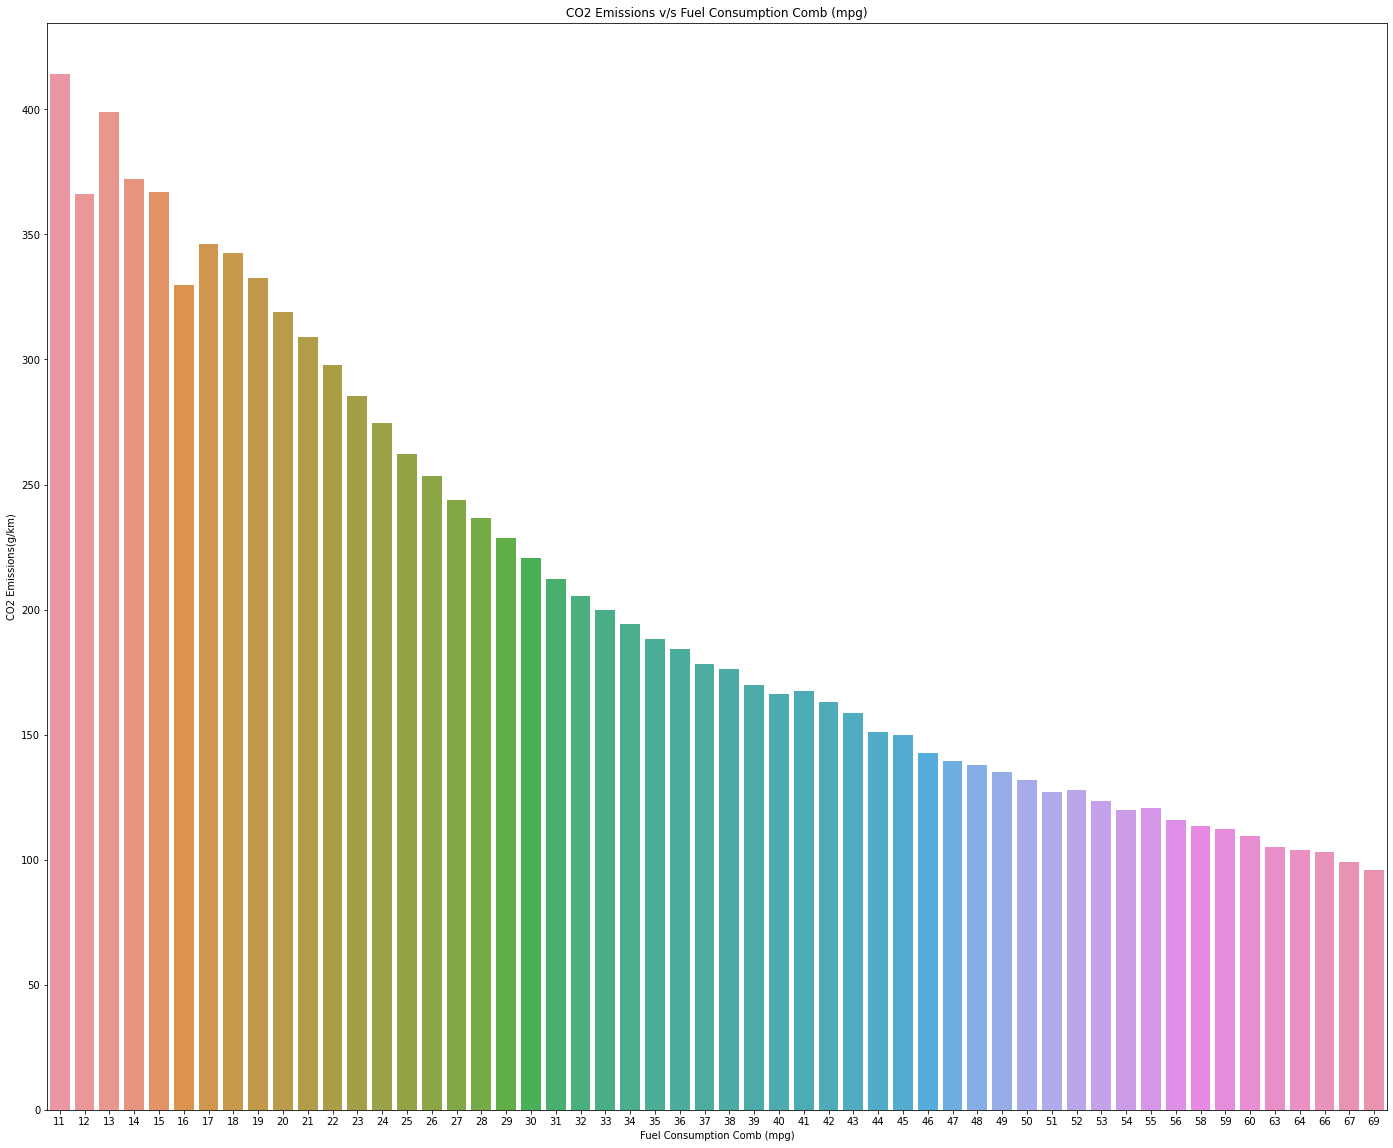

In [37]:
Comb_mpg_CO2 = df_pd.groupby('Fuel Consumption Comb (mpg)')['CO2 Emissions(g/km)'].mean().reset_index()
plt.figure(figsize=(24,20))
sns.barplot(y='CO2 Emissions(g/km)',x='Fuel Consumption Comb (mpg)',data = Comb_mpg_CO2)
plt.title('CO2 Emissions v/s Fuel Consumption Comb (mpg)')
plt.show()

- Conclusion - As Fuel Consumption Comb (mpg) increases, CO2 emissions decreases

### Feature Engineering

### 1. There are 42 unique Car Companies. We will divide these companies into Luxury, Sports, Premium and General cars

In [38]:
S = ['BUGATTI', 'PORSCHE', 'MASERATI', 'ASTON MARTIN', 'LAMBORGHINI', 'JAGUAR','SRT']
P = ['ALFA ROMEO', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHRYSLER', 'DODGE', 'GMC','INFINITI', 'JEEP', 'LAND ROVER', 'LEXUS', 'MERCEDES-BENZ','MINI', 'SMART', 'VOLVO']
L = ['ACURA', 'BENTLEY', 'LINCOLN', 'ROLLS-ROYCE',  'GENESIS']
G = ['CHEVROLET', 'FIAT', 'FORD', 'KIA', 'HONDA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI','NISSAN', 'RAM', 'SCION', 'SUBARU', 'TOYOTA','VOLKSWAGEN']

df = df.replace(S,'Sports','Make')
df = df.replace(P,'Premium','Make')
df = df.replace(L ,'Luxury','Make')
df = df.replace(G,'General','Make')

print(df.select('Make').distinct().count())
print(df.select('Make').distinct().show())
df_pd = df.toPandas()

4
+-------+
|   Make|
+-------+
|Premium|
| Sports|
|General|
| Luxury|
+-------+

None


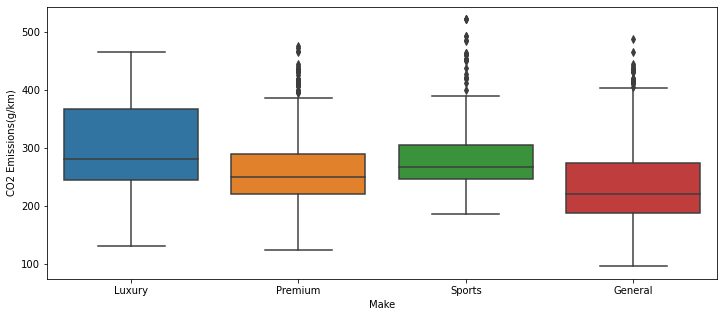

In [39]:
plt.figure(figsize = (12,5))

sns.boxplot(data = df_pd,x='Make',y ='CO2 Emissions(g/km)')
plt.show()

- Conclusion - The plot shows that Sports cars and Luxury cars emit more CO2 compared to Premium and General use cars

### 2. There are 16 unique Vehicle Classes. We will divide them into Hatchback, Sedan, SUV and Truck

In [40]:
H = ['COMPACT', 'MINICOMPACT', 'SUBCOMPACT']
S = ['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON - SMALL', 'STATION WAGON - MID-SIZE']
SUV = ['SUV - SMALL', 'SUV - STANDARD', 'MINIVAN']
T = ['VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK - SMALL']

df = df.replace(H,'Hatchback','Vehicle Class')
df = df.replace(S,'Sedan','Vehicle Class')
df = df.replace(SUV ,'SUV','Vehicle Class')
df = df.replace(T,'Truck','Vehicle Class')

print(df.select('Vehicle Class').distinct().count())
print(df.select('Vehicle Class').distinct().show())
df_pd = df.toPandas()

4
+-------------+
|Vehicle Class|
+-------------+
|    Hatchback|
|          SUV|
|        Sedan|
|        Truck|
+-------------+

None


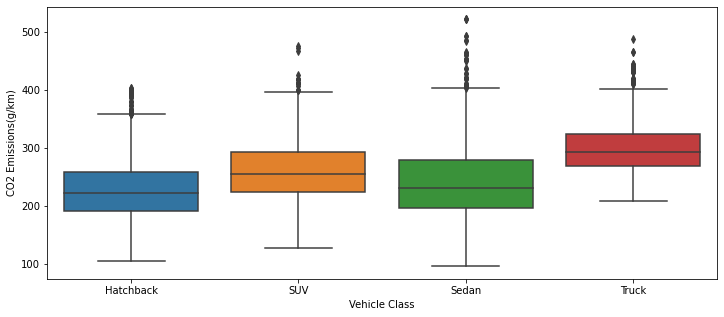

In [41]:
plt.figure(figsize = (12,5))

sns.boxplot(data = df_pd,x='Vehicle Class',y ='CO2 Emissions(g/km)')
plt.show()

- Conclusion - The plot shows that the bigger the cars are the more CO2 they emit

### Correlation Matrix

In [42]:
df_pd.corr()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
Engine Size(L),1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
Cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
Fuel Consumption City (L/100 km),0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
Fuel Consumption Hwy (L/100 km),0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
Fuel Consumption Comb (L/100 km),0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
Fuel Consumption Comb (mpg),-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
CO2 Emissions(g/km),0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


<AxesSubplot:>

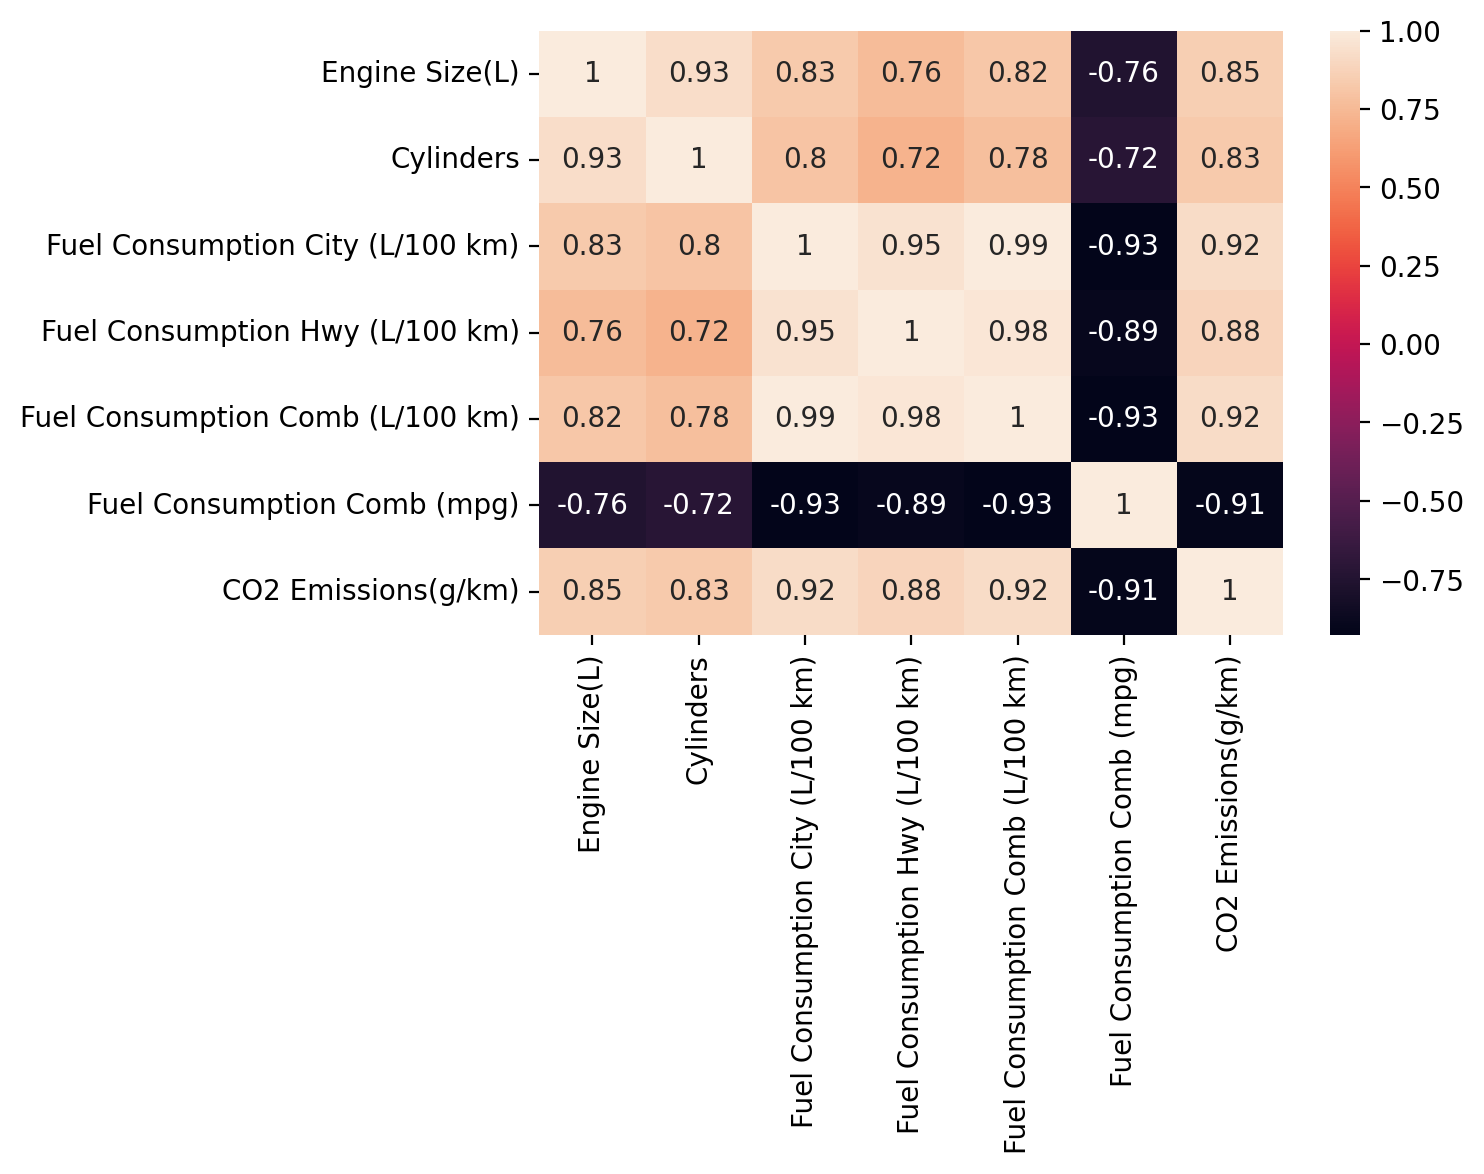

In [43]:
plt.figure(dpi = 200)
sns.heatmap(df_pd.corr(), annot = True)

### Data Preparation for ML Algorithms

In [44]:
for col in df.dtypes:
    print(col)

('Make', 'string')
('Model', 'string')
('Vehicle Class', 'string')
('Engine Size(L)', 'double')
('Cylinders', 'int')
('Transmission', 'string')
('Fuel Type', 'string')
('Fuel Consumption City (L/100 km)', 'double')
('Fuel Consumption Hwy (L/100 km)', 'double')
('Fuel Consumption Comb (L/100 km)', 'double')
('Fuel Consumption Comb (mpg)', 'int')
('CO2 Emissions(g/km)', 'int')


In [45]:
df.select('Fuel Consumption Comb (L/100 km)').distinct().count()

181

In [46]:
categorical_cols = []
numerical_cols = []

In [47]:
for col in df.drop('Fuel Consumption Comb (mpg)').dtypes:
    distinct_count = df.select(col[0]).distinct().count()
    if col[1] == 'string' and distinct_count <= 20:
            categorical_cols.append((col[0], distinct_count))
    if col[1] == 'int' or col[1] == 'double':
        numerical_cols.append((col[0], distinct_count))

In [48]:
numerical_cols

[('Engine Size(L)', 51),
 ('Cylinders', 8),
 ('Fuel Consumption City (L/100 km)', 211),
 ('Fuel Consumption Hwy (L/100 km)', 143),
 ('Fuel Consumption Comb (L/100 km)', 181),
 ('CO2 Emissions(g/km)', 331)]

In [49]:
categorical_cols

[('Make', 4), ('Vehicle Class', 4), ('Transmission', 5), ('Fuel Type', 5)]

In [50]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

### One Hot Encoding of Categorical variables

In [51]:
stages = []
indexers = [
     StringIndexer(inputCol=c[0], outputCol='{0}_indexed'.format(c[0]))
     for c in categorical_cols
   ]
input_cols = [indexer.getOutputCol() for indexer in indexers]
output_cols = ['{}_encoded'.format(indexer.getOutputCol()) for indexer in indexers]
encoders = OneHotEncoder(inputCols=input_cols, outputCols=output_cols)
stages += indexers
stages += [encoders]

In [52]:
input_cols

['Make_indexed',
 'Vehicle Class_indexed',
 'Transmission_indexed',
 'Fuel Type_indexed']

In [53]:
output_cols

['Make_indexed_encoded',
 'Vehicle Class_indexed_encoded',
 'Transmission_indexed_encoded',
 'Fuel Type_indexed_encoded']

In [54]:
encoders

OneHotEncoder_eeb0f888da78

In [55]:
indexers

[StringIndexer_e5499f6a6d0c,
 StringIndexer_0080bd3fbdd4,
 StringIndexer_2b6d2273329a,
 StringIndexer_d0d4ca72359e]

In [56]:
stages

[StringIndexer_e5499f6a6d0c,
 StringIndexer_0080bd3fbdd4,
 StringIndexer_2b6d2273329a,
 StringIndexer_d0d4ca72359e,
 OneHotEncoder_eeb0f888da78]

### Assembling all the Features using a Vector Assembler

In [57]:
assembler_input_cols = encoders.getOutputCols() + [c[0] for c in numerical_cols]
assembler = VectorAssembler(inputCols=assembler_input_cols, outputCol="vectorized_features")
stages += [assembler]

### Creating a pipeline to perform all the stages

In [58]:
pipeline = Pipeline().setStages(stages)
assembled = pipeline.fit(df)
df_assembled = assembled.transform(df)

In [59]:
df_vectorized = df_assembled.select('vectorized_features','CO2 Emissions(g/km)')

### Scaling the data with the help of a StandardScaler

In [60]:
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features",
                        withStd=True, withMean=False)

In [61]:
scaler_model = scaler.fit(df_vectorized)

In [62]:
df_scaled = scaler_model.transform(df_vectorized).drop('vectorized_features')

In [63]:
df_scaled.show()

+-------------------+--------------------+
|CO2 Emissions(g/km)|            features|
+-------------------+--------------------+
|                196|(20,[5,6,11,14,15...|
|                221|(20,[5,8,11,14,15...|
|                136|(20,[5,11,14,15,1...|
|                255|(20,[4,6,11,14,15...|
|                244|(20,[4,6,11,14,15...|
|                230|(20,[3,6,11,14,15...|
|                232|(20,[3,6,11,14,15...|
|                255|(20,[3,6,11,14,15...|
|                267|(20,[3,8,11,14,15...|
|                212|(20,[5,6,11,14,15...|
|                225|(20,[5,8,11,14,15...|
|                239|(20,[5,6,11,14,15...|
|                193|(20,[1,3,9,11,14,...|
|                359|(20,[2,5,7,11,14,...|
|                359|(20,[2,5,7,11,14,...|
|                338|(20,[2,3,9,11,14,...|
|                354|(20,[2,3,8,11,14,...|
|                338|(20,[2,3,9,11,14,...|
|                354|(20,[2,3,8,11,14,...|
|                359|(20,[2,5,7,11,14,...|
+----------

### Train, Test and Split 

In [64]:
df_train, df_test = df_scaled.randomSplit([0.8, 0.2], seed=42)

### Building the model

### 1. GBT 

In [65]:
from pyspark.ml.regression import GBTRegressor

In [66]:
gbt = GBTRegressor(labelCol="CO2 Emissions(g/km)", featuresCol="features", maxIter=10)

In [67]:
model_gbt = gbt.fit(df_train)

In [68]:
df_test_pred = model_gbt.transform(df_test)

In [69]:
df_test_pred.show()

+-------------------+--------------------+------------------+
|CO2 Emissions(g/km)|            features|        prediction|
+-------------------+--------------------+------------------+
|                 96|(20,[0,3,9,10,14,...|118.68072945804732|
|                103|(20,[0,3,9,10,14,...|118.68072945804732|
|                104|(20,[0,3,10,14,15...|118.68072945804732|
|                106|(20,[0,5,10,14,15...|136.50065377798964|
|                110|(20,[0,3,9,10,14,...|118.68072945804732|
|                110|(20,[0,3,10,14,15...|126.48318819630992|
|                114|(20,[0,3,9,10,14,...|118.68072945804732|
|                114|(20,[0,3,10,14,15...|126.48318819630992|
|                120|(20,[0,5,10,14,15...|134.43602032991453|
|                120|(20,[0,5,10,14,15...|134.43602032991453|
|                121|(20,[0,3,10,14,15...|118.68072945804732|
|                121|(20,[0,3,10,14,15...|118.68072945804732|
|                121|(20,[0,3,10,14,15...|123.37502653695192|
|       

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
rmse_evaluator = RegressionEvaluator(
    labelCol="CO2 Emissions(g/km)", predictionCol="prediction", metricName="rmse")

In [72]:
r2_evaluator = RegressionEvaluator(
    labelCol="CO2 Emissions(g/km)", predictionCol="prediction", metricName="r2")

In [73]:
r2_evaluator.evaluate(df_test_pred)

0.9944752627305882

In [74]:
rmse_evaluator.evaluate(df_test_pred)

4.234135761727646

### 2. Random Forest

In [75]:
from pyspark.ml.regression import RandomForestRegressor

In [76]:
rf = RandomForestRegressor(labelCol="CO2 Emissions(g/km)", featuresCol="features", numTrees=10)

In [77]:
model_rf = rf.fit(df_train)

In [78]:
df_test_pred = model_rf.transform(df_test)

In [79]:
df_test_pred.show()

+-------------------+--------------------+------------------+
|CO2 Emissions(g/km)|            features|        prediction|
+-------------------+--------------------+------------------+
|                 96|(20,[0,3,9,10,14,...|130.39688647304808|
|                103|(20,[0,3,9,10,14,...|130.39688647304808|
|                104|(20,[0,3,10,14,15...|130.39688647304808|
|                106|(20,[0,5,10,14,15...|136.25348674132988|
|                110|(20,[0,3,9,10,14,...|130.39688647304808|
|                110|(20,[0,3,10,14,15...|130.39688647304808|
|                114|(20,[0,3,9,10,14,...|130.39688647304808|
|                114|(20,[0,3,10,14,15...|130.39688647304808|
|                120|(20,[0,5,10,14,15...|135.14466321191807|
|                120|(20,[0,5,10,14,15...|135.14466321191807|
|                121|(20,[0,3,10,14,15...|130.39688647304808|
|                121|(20,[0,3,10,14,15...|130.39688647304808|
|                121|(20,[0,3,10,14,15...|130.39688647304808|
|       

In [80]:
r2_evaluator.evaluate(df_test_pred)

0.987432413484538

In [81]:
rmse_evaluator.evaluate(df_test_pred)

6.386088103492938

### 3. Decision Tree

In [82]:
from pyspark.ml.regression import DecisionTreeRegressor

In [83]:
dt = DecisionTreeRegressor(labelCol="CO2 Emissions(g/km)", featuresCol="features")

In [84]:
model_dt = dt.fit(df_train)

In [85]:
df_test_pred = model_dt.transform(df_test)

In [86]:
df_test_pred.show()

+-------------------+--------------------+------------------+
|CO2 Emissions(g/km)|            features|        prediction|
+-------------------+--------------------+------------------+
|                 96|(20,[0,3,9,10,14,...|129.23584905660377|
|                103|(20,[0,3,9,10,14,...|129.23584905660377|
|                104|(20,[0,3,10,14,15...|129.23584905660377|
|                106|(20,[0,5,10,14,15...|144.18032786885246|
|                110|(20,[0,3,9,10,14,...|129.23584905660377|
|                110|(20,[0,3,10,14,15...|129.23584905660377|
|                114|(20,[0,3,9,10,14,...|129.23584905660377|
|                114|(20,[0,3,10,14,15...|129.23584905660377|
|                120|(20,[0,5,10,14,15...|144.18032786885246|
|                120|(20,[0,5,10,14,15...|144.18032786885246|
|                121|(20,[0,3,10,14,15...|129.23584905660377|
|                121|(20,[0,3,10,14,15...|129.23584905660377|
|                121|(20,[0,3,10,14,15...|129.23584905660377|
|       

In [87]:
r2_evaluator.evaluate(df_test_pred)

0.991801086676507

In [88]:
rmse_evaluator.evaluate(df_test_pred)

5.158068574818637

#### 4. Linear Regression

In [89]:
from pyspark.ml.regression import LinearRegression

In [90]:
lr = LinearRegression(labelCol="CO2 Emissions(g/km)", featuresCol="features")

In [91]:
model_lr = lr.fit(df_train)

In [92]:
df_test_pred = model_lr.transform(df_test)

In [93]:
df_test_pred.show()

+-------------------+--------------------+------------------+
|CO2 Emissions(g/km)|            features|        prediction|
+-------------------+--------------------+------------------+
|                 96|(20,[0,3,9,10,14,...| 96.00000000009851|
|                103|(20,[0,3,9,10,14,...|103.00000000009412|
|                104|(20,[0,3,10,14,15...| 104.0000000000873|
|                106|(20,[0,5,10,14,15...| 106.0000000000692|
|                110|(20,[0,3,9,10,14,...|110.00000000008332|
|                110|(20,[0,3,10,14,15...|110.00000000009076|
|                114|(20,[0,3,9,10,14,...|114.00000000004819|
|                114|(20,[0,3,10,14,15...|114.00000000009105|
|                120|(20,[0,5,10,14,15...|120.00000000002116|
|                120|(20,[0,5,10,14,15...|120.00000000006835|
|                121|(20,[0,3,10,14,15...|121.00000000002832|
|                121|(20,[0,3,10,14,15...|121.00000000002832|
|                121|(20,[0,3,10,14,15...|121.00000000004563|
|       

In [94]:
r2_evaluator.evaluate(df_test_pred)

1.0

In [95]:
rmse_evaluator.evaluate(df_test_pred)

6.286052696405085e-11

In [96]:
df_train_pred = model_lr.transform(df_train)

In [97]:
df_train_pred.show()

+-------------------+--------------------+------------------+
|CO2 Emissions(g/km)|            features|        prediction|
+-------------------+--------------------+------------------+
|                 96|(20,[0,3,9,10,14,...| 96.00000000009851|
|                 96|(20,[0,3,9,10,14,...| 96.00000000009851|
|                 96|(20,[0,3,9,10,14,...| 96.00000000009851|
|                 99|(20,[0,3,9,10,14,...| 99.00000000008743|
|                102|(20,[0,3,9,10,14,...|102.00000000006993|
|                104|(20,[0,3,9,10,14,...|104.00000000005016|
|                105|(20,[0,3,10,14,15...|105.00000000008383|
|                105|(20,[0,3,10,14,15...|105.00000000004337|
|                105|(20,[0,3,10,14,15...|105.00000000007742|
|                106|(20,[0,3,10,14,15...| 106.0000000000598|
|                108|(20,[0,3,10,14,15...|108.00000000007985|
|                108|(20,[0,5,10,14,15...|108.00000000006922|
|                109|(20,[0,3,10,14,15...|109.00000000007635|
|       

In [98]:
r2_evaluator.evaluate(df_train_pred)

1.0

In [99]:
rmse_evaluator.evaluate(df_train_pred)

6.472594509526192e-11

### Summary 

### 1.  As we see each regression model specially Linear Regression model is giving us good R2 score and minimum RMSE value. The fact behind this must be the dataset we took here consists of only 7385 rows but still we are able to see the patterns which will help us understand the process.

### 2. If we look carefully at the predictions except for the Linear Regression all other models are predicting values away from the true values. The reason is Linear relationship between the Dependant and Independant variable. 

### 3.. The main point is because of the scale and speed of the Spark we can utilize SparkML for large datasets too.


In [100]:
spark.stop()